# 02 Huia Experience Training

### Reference
https://www.tensorflow.org/alpha/tutorials/load_data/images

## TODOS
- interpret layers visually
- tensorboard convergence
https://github.com/titu1994/keras-one-cycle
https://www.kaggle.com/robotdreams/one-cycle-policy-with-keras 

# Setup 
## Install Tensorflow 2 Nightly and other Libraries

In [1]:
# tf addons only works with alpha for now
#!pip install tensorflow-gpu==2.0.0-alpha0 
#!pip install tensorflow-estimator
#!pip install fastai
#!pip install tensorflow-addons


#nigthly packages (not working with addons)
#!pip install --upgrade --force-reinstall tf-nightly-gpu-2.0-preview
#!pip install tensorflow-addons --upgrade --force-reinstall -> build from sources https://github.com/tensorflow/addons
#!pip install tensorflow-estimator==2.0.0-alpha0  --upgrade --force-reinstall

!pip freeze | egrep 'tensor|tb'

-e git+https://github.com/onnx/onnx-tensorflow.git@40e80fe0e8c49e268d537b0104979a3d50f6b0fa#egg=onnx_tf
tb-nightly==1.14.0a20190301
tblib==1.3.2
tensorboard==1.13.1
tensorboardX==1.6
tensorflow==1.9.0
tensorflow-estimator==1.13.0
tensorflow-estimator-2.0-preview==1.14.0.dev2019032600
tensorflow-gpu==1.13.1
tensorflow-hub==0.3.0
tensorflowjs==1.0.1


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import pathlib
import os
import random

# enable logging to make sure we are running on the GPU
tf.debugging.set_log_device_placement(True)

In [4]:
# clear any active session
tf.keras.backend.clear_session()

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64

# Data
We have to understand well our data as this is fundamental to achieve good results.

In [5]:
root_path = pathlib.Path("./training_data/")
image_path = root_path /"images"
json_path = root_path /"json"
augmented_path = root_path/"augmented_imgs"

image_path,json_path ,augmented_path

(PosixPath('training_data/images'),
 PosixPath('training_data/json'),
 PosixPath('training_data/augmented_imgs'))

In [6]:
# lets set the random seed so we can reproduce our results
random.seed(7)

# get filenames from directories 
all_image_paths = list(image_path.glob('*.png')) + list(augmented_path.glob('*.png'))
#all_json_paths = list(json_path.glob('*.json'))

all_image_paths = [str(path) for path in all_image_paths] # convert to strings
random.shuffle(all_image_paths) # randomize

In [7]:
len(all_image_paths)#, len(all_json_paths)

4191

In [8]:
all_image_paths[:20] 

['training_data/augmented_imgs/wings_423999.png',
 'training_data/augmented_imgs/dramatic_1257994.png',
 'training_data/augmented_imgs/fly_440994.png',
 'training_data/augmented_imgs/normal_808991.png',
 'training_data/augmented_imgs/normal_2999.png',
 'training_data/augmented_imgs/moonwalk_74998.png',
 'training_data/augmented_imgs/normal_805990.png',
 'training_data/augmented_imgs/underarm_244991.png',
 'training_data/augmented_imgs/fly_841995.png',
 'training_data/images/dramatic_556.png',
 'training_data/augmented_imgs/dramatic_564993.png',
 'training_data/augmented_imgs/wings_426996.png',
 'training_data/augmented_imgs/hadouken_970994.png',
 'training_data/augmented_imgs/normal_18993.png',
 'training_data/augmented_imgs/dramatic_123990.png',
 'training_data/augmented_imgs/dramatic_1265998.png',
 'training_data/augmented_imgs/hadouken_969995.png',
 'training_data/augmented_imgs/fly_232999.png',
 'training_data/augmented_imgs/hadouken_93996.png',
 'training_data/augmented_imgs/under

In [9]:
import re
# extract categories for classification
pat = r'/([^/]+)_\d+.png$'
all_image_labels = [str(re.search(pat,str(image)).group(1)).lower() for image in all_image_paths]
len(all_image_labels)

4191

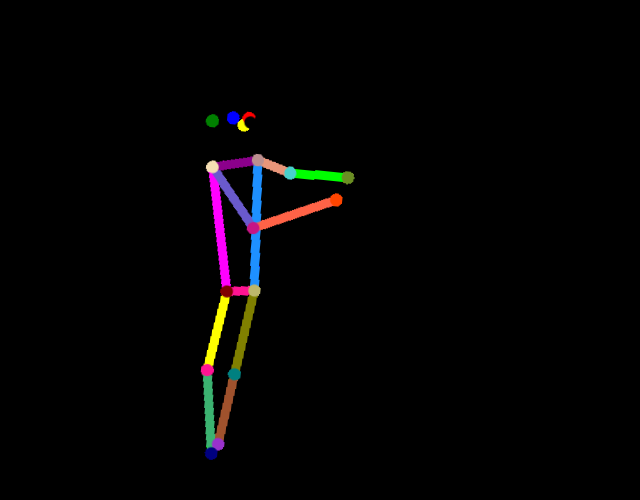

file: training_data/augmented_imgs/hadouken_94999.png


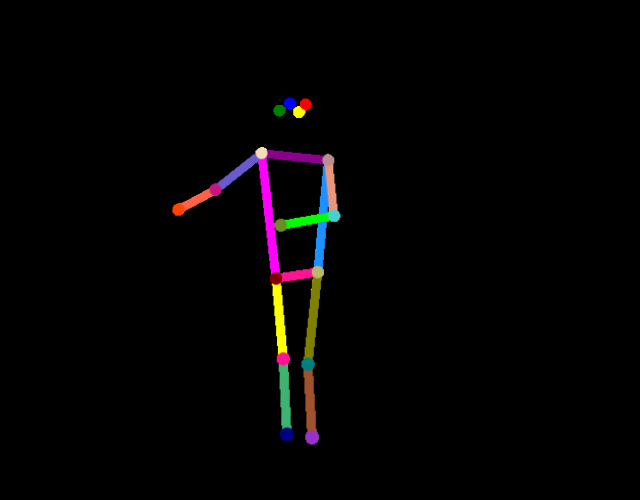

file: training_data/augmented_imgs/backpack_108991.png


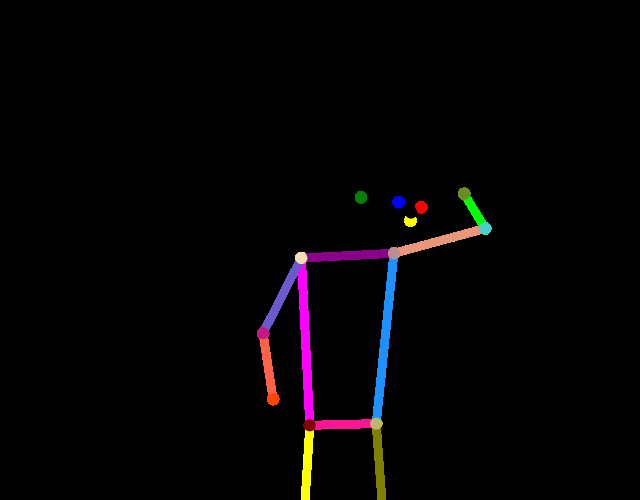

file: training_data/augmented_imgs/underarm_460991.png


In [10]:
import IPython.display as display
import matplotlib.pyplot as plt

# lets check samples of our images to see what they look like
for n in range(3):  
    image = random.choice(all_image_paths)
    display.display(display.Image(str(image)))
    print(f"file: {image}")

In [11]:
# get unique classes
huia_person=[]
for label in all_image_labels:
    if label not in huia_person:
        huia_person.append(label)
huia_person = sorted(huia_person) # sort label list
huia_person

['backpack',
 'dramatic',
 'fly',
 'hadouken',
 'moonwalk',
 'normal',
 'underarm',
 'wings']

In [12]:
# put them in a dict for lookup
label_to_index = dict((name, index) for index,name in enumerate(huia_person))
label_to_index

{'backpack': 0,
 'dramatic': 1,
 'fly': 2,
 'hadouken': 3,
 'moonwalk': 4,
 'normal': 5,
 'underarm': 6,
 'wings': 7}

In [13]:
# lets format it, so we can copy and paste the dict direclty into javascript :-)
print("POSE_CLASSES = {")
for index,name in enumerate(huia_person):
    print("\t" +str(index)+": '"+name+"',")
print("}")

POSE_CLASSES = {
	0: 'backpack',
	1: 'dramatic',
	2: 'fly',
	3: 'hadouken',
	4: 'moonwalk',
	5: 'normal',
	6: 'underarm',
	7: 'wings',
}


(500, 640, 3)
<dtype: 'uint8'>


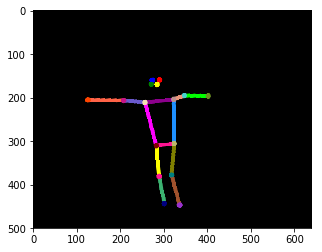

In [14]:
# load data into tf data
img_raw = tf.io.read_file(all_image_paths[0])
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)
plt.imshow(img_tensor)

#img_raw.numpy()




In [15]:
import numpy
from random import randint
import math

def  preprocess_image(image):
    #print("EagerMode:" + str(tf.executing_eagerly()))
    # decode PNG
    image = tf.image.decode_png(image, channels=3)    
    
    # data augmentation - doing statically via fastai, as tensorflow addons is not compatible with graph mode yet 
    # rotate random
    degrees = random.randint(-6,6)
    angle = degrees * math.pi / 180
    #image = tfa.image.rotate(image,angle,interpolation='BILINEAR')
    
    # random crop - images are tensors of shape (500,640,3)
    crop_factor = (random.randint(0,20)/100) # generate numbers between 0.7 and 1.0
    new_width = int(640 * (1-crop_factor))
    new_height = int(500 * (1-crop_factor))
    # resize_image_with_crop_or_pad
    # image = tf.image.resize_image_with_crop_or_pad(image,new_height,new_width)
    
    # resize
    image = tf.image.resize(image, [224, 224])

    # normalize = convert to [-1:1]    
    offset = 127.5
    image = (image-offset)/offset
    return image

def load_and_preprocess_image(path):    
    image = tf.io.read_file(path)
    return preprocess_image(image)


W0514 14:05:52.819058 140533261432640 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


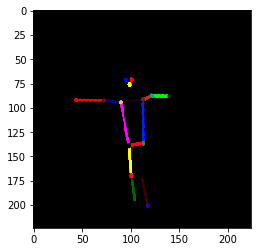

In [16]:
# load data into tf data
img_tensor = load_and_preprocess_image(all_image_paths[0])
plt.imshow(img_tensor)

In [17]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
path_ds

next(iter(path_ds))

<tf.Tensor: id=43, shape=(), dtype=string, numpy=b'training_data/augmented_imgs/wings_423999.png'>

In [18]:
# force non performatic eager mode as tfa.image doesn't support graph mode yet
#image_ds = path_ds.map(lambda path: tf.py_function(func=load_and_preprocess_image,inp=[path],Tout=tf.float32))
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls = AUTOTUNE)

In [19]:
all_image_labels_idx = [label_to_index[label] for label in all_image_labels]
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels_idx, tf.int64))
len(all_image_labels)

4191

In [20]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds
image_count = len(all_image_labels)

type(image_label_ds)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [21]:
ds = image_label_ds.cache()
ds = ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [22]:
# we will use a pretrained mobilenet for transferlearning
mobilenet = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
mobilenet.trainable = False
mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [23]:
image_batch, label_batch = next(iter(ds))
print(image_batch.shape)

(64, 224, 224, 3)


In [24]:
label_batch[0].numpy()
image_batch[0].numpy()

array([[[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       ...,

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]],

       [[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        ...,
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]]

In [25]:
feature_map_batch = mobilenet(image_batch)
print(feature_map_batch.shape)

(64, 7, 7, 1280)


In [26]:
model = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024,activation='relu',bias_initializer=tf.keras.initializers.he_normal()),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512,activation='relu',bias_initializer=tf.keras.initializers.he_normal(),name='features'),
    tf.keras.layers.Dense(len(huia_person),activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [27]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.05360333
max logit: 0.23482509

Shape: (64, 8)


In [28]:
len(model.trainable_variables) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

In [29]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

66.0

In [30]:
from datetime import datetime
now = datetime.now()
log_dir = "./logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

callbacks = []

# logging
tbCallback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
tbCallback.set_model(model)
callbacks.append(tbCallback)

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy')>0.9):
#       print("\nReached 60% accuracy so cancelling training!")
#       self.model.stop_training = True
from datetime import datetime

# earlyStopping = tf.keras.callbacks.EarlyStopping(patience=2, monitor='loss')
# callbacks.append(earlyStopping)

# chkPoint = tf.keras.callbacks.ModelCheckpoint('./models.h5')
# chkPoint.set_model(model)
# callbacks.append(chkPoint)

In [31]:
#ds.shuffle(buffer_size=32)
# skip 20% validation images
test_dataset = ds.take(838) 
train_dataset = ds.skip(838)

In [80]:
mobilenet.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
model.fit(train_dataset, epochs=20,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/20
66/66 [==============================] - 27s 409ms/step - loss: 0.7701 - accuracy: 0.7417 - val_loss: 1.7411 - val_accuracy: 0.4150
Epoch 2/20
66/66 [==============================] - 11s 159ms/step - loss: 0.1638 - accuracy: 0.9444 - val_loss: 1.3573 - val_accuracy: 0.5613
Epoch 3/20
66/66 [==============================] - 11s 163ms/step - loss: 0.0859 - accuracy: 0.9735 - val_loss: 1.2229 - val_accuracy: 0.6056
Epoch 4/20
66/66 [==============================] - 11s 161ms/step - loss: 0.0779 - accuracy: 0.9754 - val_loss: 1.0536 - val_accuracy: 0.6004
Epoch 5/20
66/66 [==============================] - 11s 162ms/step - loss: 0.0709 - accuracy: 0.9759 - val_loss: 0.8922 - val_accuracy: 0.6643
Epoch 6/20
66/66 [==============================] - 11s 163ms/step - loss: 0.0522 - accuracy: 0.9825 - val_loss: 1.3299 - val_accuracy: 0.5691
Epoch 7/20
66/66 [==============================] - 11s 160ms/step - loss: 0.0446 - accuracy: 0.9863 - val_loss: 1.6505 - val_accuracy: 0.5355

In [82]:
mobilenet.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-07, amsgrad=False), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [83]:
model.fit(train_dataset, epochs=100,steps_per_epoch=steps_per_epoch,verbose=1,validation_data=test_dataset,
          callbacks=callbacks)

Epoch 1/100
66/66 [==============================] - 64s 975ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.6540 - val_accuracy: 0.8078
Epoch 2/100
66/66 [==============================] - 27s 415ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 0.5647 - val_accuracy: 0.8348
Epoch 3/100
66/66 [==============================] - 27s 410ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 0.4969 - val_accuracy: 0.8523
Epoch 4/100
66/66 [==============================] - 27s 408ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.4433 - val_accuracy: 0.8643
Epoch 5/100
66/66 [==============================] - 27s 415ms/step - loss: 0.0070 - accuracy: 0.9979 - val_loss: 0.3930 - val_accuracy: 0.8800
Epoch 6/100
66/66 [==============================] - 27s 416ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.3568 - val_accuracy: 0.9008
Epoch 7/100
66/66 [==============================] - 27s 412ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.3012 - val_accuracy:

In [84]:
model.save("models/huia_mob_224_final.h5") # 1.0

In [85]:
model

# Convert to TENSORFLOW JS / Quantization

In [86]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_final_q16",quantization_dtype=np.uint16)
tfjs.converters.save_keras_model(model, "models_tfjs/tfjs_huia_mob_224_final_q8",quantization_dtype=np.uint8)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,'model.png',show_layer_names=False) #,show_shapes=True)

# Tensorboard Visualization

In [ ]:
# https://www.tensorflow.org/tensorboard/
import tensorboard as tb
%load_ext tensorboard.notebook

#notebook.list() # View open TensorBoard instances
#notebook.display(port=6006, height=1000)
#!kill 25264

In [ ]:
%tensorboard --logdir ./logs

In [ ]:
timeit(ds)

# Predict

In [ ]:
import numpy as np
sample = np.reshape(img_final,[1,224,224,3])

predict = int(model.predict_classes(sample))
predict

In [ ]:
[key for key,value in label_to_index.items() if value == predict]

In [ ]:
label_to_index

# UTILS

## Delete Images that are empty

In [ ]:
# during image capture some images are empty, so we automatically delete them

# open images and delete if they are empty
def remove_empty_imgs(imgpath):
    for item in imgpath.iterdir():
        im = imread(str(item), format='png')
        if np.count_nonzero(im)==0: 
            print(item,np.count_nonzero(im))
            os.remove(str(item))
            
#remove_empty_imgs(image_path)

## Sync JSONs with Images

In [ ]:
# since we might delete unwanted images for training, this will also delete the json files
# sync json & images 

def sync_json_images(json_paths, img_path):
    for json in json_paths:
        #print(json.stem, end=" ")
        img = img_path/f"{json.stem}.png"
        if not Path(img).exists():
            print(f"{img} doesn't exist, deleting {json}")
            Path(json).unlink()
        
#sync_json_images(all_json_paths, image_path)

# Static Data Augmentation
Decided to use FASTAI to statically preprocess data augmentation, as tensorflow addons (0.3.1) still didn't support graph mode and is therefore not compatible with tf.data.Dataset mappings




In [25]:
from fastai.vision import *
from fastai.metrics import error_rate
from random import randint
import pathlib

root_path = pathlib.Path("./training_data/")
save_fast = Path('./training_data/augmented_imgs/')
save_fast.mkdir(parents=True, exist_ok=True)

tfms = get_transforms(do_flip=False, 
                            flip_vert=False, 
                            max_rotate=6, 
                            max_zoom=1.2, 
                            max_lighting=None, 
                            max_warp=0.2, 
                            p_affine=0.2, 
                            p_lighting=0)


image_path = root_path /"images"
all_image_paths = list(image_path.glob('*.png'))


def generate_augmented(qty):
    for f in all_image_paths:
        image = open_image(f)
        for i in range(0,qty):
            image_fast = image.apply_tfms(tfms[0])
            save_name = str(save_fast) + '/' + f.stem + '99' + str(i) + f.suffix
            print(save_name)
            image_fast.save(save_name)

# generate 10 variations of each image
# generate_augmented(10)

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_811990.png
training_data/augmented_imgs/normal_811991.png
training_data/augmented_imgs/normal_811992.png
training_data/augmented_imgs/normal_811993.png
training_data/augmented_imgs/normal_811994.png
training_data/augmented_imgs/normal_811995.png
training_data/augmented_imgs/normal_811996.png
training_data/augmented_imgs/normal_811997.png
training_data/augmented_imgs/normal_811998.png
training_data/augmented_imgs/normal_811999.png
training_data/augmented_imgs/dramatic_297990.png
training_data/augmented_imgs/dramatic_297991.png
training_data/augmented_imgs/dramatic_297992.png
training_data/augmented_imgs/dramatic_297993.png
training_data/augmented_imgs/dramatic_297994.png
training_data/augmented_imgs/dramatic_297995.png
training_data/augmented_imgs/dramatic_297996.png
training_data/augmented_imgs/dramatic_297997.png
training_data/augmented_imgs/dramatic_297998.png
training_data/augmented_imgs/dramatic_297999.png
training_data/augmented_imgs/wings_42599

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_425996.png
training_data/augmented_imgs/wings_425997.png
training_data/augmented_imgs/wings_425998.png
training_data/augmented_imgs/wings_425999.png
training_data/augmented_imgs/wings_417990.png
training_data/augmented_imgs/wings_417991.png
training_data/augmented_imgs/wings_417992.png
training_data/augmented_imgs/wings_417993.png
training_data/augmented_imgs/wings_417994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_417995.png
training_data/augmented_imgs/wings_417996.png
training_data/augmented_imgs/wings_417997.png
training_data/augmented_imgs/wings_417998.png
training_data/augmented_imgs/wings_417999.png
training_data/augmented_imgs/hadouken_1237990.png
training_data/augmented_imgs/hadouken_1237991.png
training_data/augmented_imgs/hadouken_1237992.png
training_data/augmented_imgs/hadouken_1237993.png
training_data/augmented_imgs/hadouken_1237994.png
training_data/augmented_imgs/hadouken_1237995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_1237996.png
training_data/augmented_imgs/hadouken_1237997.png
training_data/augmented_imgs/hadouken_1237998.png
training_data/augmented_imgs/hadouken_1237999.png
training_data/augmented_imgs/wings_220990.png
training_data/augmented_imgs/wings_220991.png
training_data/augmented_imgs/wings_220992.png
training_data/augmented_imgs/wings_220993.png
training_data/augmented_imgs/wings_220994.png
training_data/augmented_imgs/wings_220995.png
training_data/augmented_imgs/wings_220996.png
training_data/augmented_imgs/wings_220997.png
training_data/augmented_imgs/wings_220998.png
training_data/augmented_imgs/wings_220999.png
training_data/augmented_imgs/hadouken_967990.png
training_data/augmented_imgs/hadouken_967991.png
training_data/augmented_imgs/hadouken_967992.png
training_data/augmented_imgs/hadouken_967993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_967994.png
training_data/augmented_imgs/hadouken_967995.png
training_data/augmented_imgs/hadouken_967996.png
training_data/augmented_imgs/hadouken_967997.png
training_data/augmented_imgs/hadouken_967998.png
training_data/augmented_imgs/hadouken_967999.png
training_data/augmented_imgs/wings_37990.png
training_data/augmented_imgs/wings_37991.png
training_data/augmented_imgs/wings_37992.png
training_data/augmented_imgs/wings_37993.png
training_data/augmented_imgs/wings_37994.png
training_data/augmented_imgs/wings_37995.png
training_data/augmented_imgs/wings_37996.png
training_data/augmented_imgs/wings_37997.png
training_data/augmented_imgs/wings_37998.png
training_data/augmented_imgs/wings_37999.png
training_data/augmented_imgs/moonwalk_74990.png
training_data/augmented_imgs/moonwalk_74991.png
training_data/augmented_imgs/moonwalk_74992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_74993.png
training_data/augmented_imgs/moonwalk_74994.png
training_data/augmented_imgs/moonwalk_74995.png
training_data/augmented_imgs/moonwalk_74996.png
training_data/augmented_imgs/moonwalk_74997.png
training_data/augmented_imgs/moonwalk_74998.png
training_data/augmented_imgs/moonwalk_74999.png
training_data/augmented_imgs/moonwalk_250990.png
training_data/augmented_imgs/moonwalk_250991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_250992.png
training_data/augmented_imgs/moonwalk_250993.png
training_data/augmented_imgs/moonwalk_250994.png
training_data/augmented_imgs/moonwalk_250995.png
training_data/augmented_imgs/moonwalk_250996.png
training_data/augmented_imgs/moonwalk_250997.png
training_data/augmented_imgs/moonwalk_250998.png
training_data/augmented_imgs/moonwalk_250999.png
training_data/augmented_imgs/dramatic_1256990.png
training_data/augmented_imgs/dramatic_1256991.png
training_data/augmented_imgs/dramatic_1256992.png
training_data/augmented_imgs/dramatic_1256993.png
training_data/augmented_imgs/dramatic_1256994.png
training_data/augmented_imgs/dramatic_1256995.png
training_data/augmented_imgs/dramatic_1256996.png
training_data/augmented_imgs/dramatic_1256997.png
training_data/augmented_imgs/dramatic_1256998.png
training_data/augmented_imgs/dramatic_1256999.png
training_data/augmented_imgs/hadouken_262990.png
training_data/augmented_imgs/hadouken_262991.png
training_d

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_262998.png
training_data/augmented_imgs/hadouken_262999.png
training_data/augmented_imgs/dramatic_555990.png
training_data/augmented_imgs/dramatic_555991.png
training_data/augmented_imgs/dramatic_555992.png
training_data/augmented_imgs/dramatic_555993.png
training_data/augmented_imgs/dramatic_555994.png
training_data/augmented_imgs/dramatic_555995.png
training_data/augmented_imgs/dramatic_555996.png
training_data/augmented_imgs/dramatic_555997.png
training_data/augmented_imgs/dramatic_555998.png
training_data/augmented_imgs/dramatic_555999.png
training_data/augmented_imgs/normal_208990.png
training_data/augmented_imgs/normal_208991.png
training_data/augmented_imgs/normal_208992.png
training_data/augmented_imgs/normal_208993.png
training_data/augmented_imgs/normal_208994.png
training_data/augmented_imgs/normal_208995.png
training_data/augmented_imgs/normal_208996.png
training_data/augmented_imgs/normal_208997.png
training_data/augmented_imgs/normal_

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_208999.png
training_data/augmented_imgs/underarm_460990.png
training_data/augmented_imgs/underarm_460991.png
training_data/augmented_imgs/underarm_460992.png
training_data/augmented_imgs/underarm_460993.png
training_data/augmented_imgs/underarm_460994.png
training_data/augmented_imgs/underarm_460995.png
training_data/augmented_imgs/underarm_460996.png
training_data/augmented_imgs/underarm_460997.png
training_data/augmented_imgs/underarm_460998.png
training_data/augmented_imgs/underarm_460999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_815990.png
training_data/augmented_imgs/normal_815991.png
training_data/augmented_imgs/normal_815992.png
training_data/augmented_imgs/normal_815993.png
training_data/augmented_imgs/normal_815994.png
training_data/augmented_imgs/normal_815995.png
training_data/augmented_imgs/normal_815996.png
training_data/augmented_imgs/normal_815997.png
training_data/augmented_imgs/normal_815998.png
training_data/augmented_imgs/normal_815999.png
training_data/augmented_imgs/wings_423990.png
training_data/augmented_imgs/wings_423991.png
training_data/augmented_imgs/wings_423992.png
training_data/augmented_imgs/wings_423993.png
training_data/augmented_imgs/wings_423994.png
training_data/augmented_imgs/wings_423995.png
training_data/augmented_imgs/wings_423996.png
training_data/augmented_imgs/wings_423997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_423998.png
training_data/augmented_imgs/wings_423999.png
training_data/augmented_imgs/backpack_526990.png
training_data/augmented_imgs/backpack_526991.png
training_data/augmented_imgs/backpack_526992.png
training_data/augmented_imgs/backpack_526993.png
training_data/augmented_imgs/backpack_526994.png
training_data/augmented_imgs/backpack_526995.png
training_data/augmented_imgs/backpack_526996.png
training_data/augmented_imgs/backpack_526997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_526998.png
training_data/augmented_imgs/backpack_526999.png
training_data/augmented_imgs/fly_437990.png
training_data/augmented_imgs/fly_437991.png
training_data/augmented_imgs/fly_437992.png
training_data/augmented_imgs/fly_437993.png
training_data/augmented_imgs/fly_437994.png
training_data/augmented_imgs/fly_437995.png
training_data/augmented_imgs/fly_437996.png
training_data/augmented_imgs/fly_437997.png
training_data/augmented_imgs/fly_437998.png
training_data/augmented_imgs/fly_437999.png
training_data/augmented_imgs/dramatic_1251990.png
training_data/augmented_imgs/dramatic_1251991.png
training_data/augmented_imgs/dramatic_1251992.png
training_data/augmented_imgs/dramatic_1251993.png
training_data/augmented_imgs/dramatic_1251994.png
training_data/augmented_imgs/dramatic_1251995.png
training_data/augmented_imgs/dramatic_1251996.png
training_data/augmented_imgs/dramatic_1251997.png
training_data/augmented_imgs/dramatic_1251998.png
training_dat

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_133997.png
training_data/augmented_imgs/dramatic_133998.png
training_data/augmented_imgs/dramatic_133999.png
training_data/augmented_imgs/moonwalk_1211990.png
training_data/augmented_imgs/moonwalk_1211991.png
training_data/augmented_imgs/moonwalk_1211992.png
training_data/augmented_imgs/moonwalk_1211993.png
training_data/augmented_imgs/moonwalk_1211994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1211995.png
training_data/augmented_imgs/moonwalk_1211996.png
training_data/augmented_imgs/moonwalk_1211997.png
training_data/augmented_imgs/moonwalk_1211998.png
training_data/augmented_imgs/moonwalk_1211999.png
training_data/augmented_imgs/dramatic_293990.png
training_data/augmented_imgs/dramatic_293991.png
training_data/augmented_imgs/dramatic_293992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_293993.png
training_data/augmented_imgs/dramatic_293994.png
training_data/augmented_imgs/dramatic_293995.png
training_data/augmented_imgs/dramatic_293996.png
training_data/augmented_imgs/dramatic_293997.png
training_data/augmented_imgs/dramatic_293998.png
training_data/augmented_imgs/dramatic_293999.png
training_data/augmented_imgs/moonwalk_1229990.png
training_data/augmented_imgs/moonwalk_1229991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1229992.png
training_data/augmented_imgs/moonwalk_1229993.png
training_data/augmented_imgs/moonwalk_1229994.png
training_data/augmented_imgs/moonwalk_1229995.png
training_data/augmented_imgs/moonwalk_1229996.png
training_data/augmented_imgs/moonwalk_1229997.png
training_data/augmented_imgs/moonwalk_1229998.png
training_data/augmented_imgs/moonwalk_1229999.png
training_data/augmented_imgs/backpack_533990.png
training_data/augmented_imgs/backpack_533991.png
training_data/augmented_imgs/backpack_533992.png
training_data/augmented_imgs/backpack_533993.png
training_data/augmented_imgs/backpack_533994.png
training_data/augmented_imgs/backpack_533995.png
training_data/augmented_imgs/backpack_533996.png
training_data/augmented_imgs/backpack_533997.png
training_data/augmented_imgs/backpack_533998.png
training_data/augmented_imgs/backpack_533999.png
training_data/augmented_imgs/hadouken_1239990.png
training_data/augmented_imgs/hadouken_1239991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_1239992.png
training_data/augmented_imgs/hadouken_1239993.png
training_data/augmented_imgs/hadouken_1239994.png
training_data/augmented_imgs/hadouken_1239995.png
training_data/augmented_imgs/hadouken_1239996.png
training_data/augmented_imgs/hadouken_1239997.png
training_data/augmented_imgs/hadouken_1239998.png
training_data/augmented_imgs/hadouken_1239999.png
training_data/augmented_imgs/underarm_70990.png
training_data/augmented_imgs/underarm_70991.png
training_data/augmented_imgs/underarm_70992.png
training_data/augmented_imgs/underarm_70993.png
training_data/augmented_imgs/underarm_70994.png
training_data/augmented_imgs/underarm_70995.png
training_data/augmented_imgs/underarm_70996.png
training_data/augmented_imgs/underarm_70997.png
training_data/augmented_imgs/underarm_70998.png
training_data/augmented_imgs/underarm_70999.png
training_data/augmented_imgs/wings_831990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_831991.png
training_data/augmented_imgs/wings_831992.png
training_data/augmented_imgs/wings_831993.png
training_data/augmented_imgs/wings_831994.png
training_data/augmented_imgs/wings_831995.png
training_data/augmented_imgs/wings_831996.png
training_data/augmented_imgs/wings_831997.png
training_data/augmented_imgs/wings_831998.png
training_data/augmented_imgs/wings_831999.png
training_data/augmented_imgs/underarm_72990.png
training_data/augmented_imgs/underarm_72991.png
training_data/augmented_imgs/underarm_72992.png
training_data/augmented_imgs/underarm_72993.png
training_data/augmented_imgs/underarm_72994.png
training_data/augmented_imgs/underarm_72995.png
training_data/augmented_imgs/underarm_72996.png
training_data/augmented_imgs/underarm_72997.png
training_data/augmented_imgs/underarm_72998.png
training_data/augmented_imgs/underarm_72999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_518990.png
training_data/augmented_imgs/hadouken_518991.png
training_data/augmented_imgs/hadouken_518992.png
training_data/augmented_imgs/hadouken_518993.png
training_data/augmented_imgs/hadouken_518994.png
training_data/augmented_imgs/hadouken_518995.png
training_data/augmented_imgs/hadouken_518996.png
training_data/augmented_imgs/hadouken_518997.png
training_data/augmented_imgs/hadouken_518998.png
training_data/augmented_imgs/hadouken_518999.png
training_data/augmented_imgs/fly_843990.png
training_data/augmented_imgs/fly_843991.png
training_data/augmented_imgs/fly_843992.png
training_data/augmented_imgs/fly_843993.png
training_data/augmented_imgs/fly_843994.png
training_data/augmented_imgs/fly_843995.png
training_data/augmented_imgs/fly_843996.png
training_data/augmented_imgs/fly_843997.png
training_data/augmented_imgs/fly_843998.png
training_data/augmented_imgs/fly_843999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_444990.png
training_data/augmented_imgs/fly_444991.png
training_data/augmented_imgs/fly_444992.png
training_data/augmented_imgs/fly_444993.png
training_data/augmented_imgs/fly_444994.png
training_data/augmented_imgs/fly_444995.png
training_data/augmented_imgs/fly_444996.png
training_data/augmented_imgs/fly_444997.png
training_data/augmented_imgs/fly_444998.png
training_data/augmented_imgs/fly_444999.png
training_data/augmented_imgs/dramatic_569990.png
training_data/augmented_imgs/dramatic_569991.png
training_data/augmented_imgs/dramatic_569992.png
training_data/augmented_imgs/dramatic_569993.png
training_data/augmented_imgs/dramatic_569994.png
training_data/augmented_imgs/dramatic_569995.png
training_data/augmented_imgs/dramatic_569996.png
training_data/augmented_imgs/dramatic_569997.png
training_data/augmented_imgs/dramatic_569998.png
training_data/augmented_imgs/dramatic_569999.png
training_data/augmented_imgs/underarm_868990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_868991.png
training_data/augmented_imgs/underarm_868992.png
training_data/augmented_imgs/underarm_868993.png
training_data/augmented_imgs/underarm_868994.png
training_data/augmented_imgs/underarm_868995.png
training_data/augmented_imgs/underarm_868996.png
training_data/augmented_imgs/underarm_868997.png
training_data/augmented_imgs/underarm_868998.png
training_data/augmented_imgs/underarm_868999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_209990.png
training_data/augmented_imgs/normal_209991.png
training_data/augmented_imgs/normal_209992.png
training_data/augmented_imgs/normal_209993.png
training_data/augmented_imgs/normal_209994.png
training_data/augmented_imgs/normal_209995.png
training_data/augmented_imgs/normal_209996.png
training_data/augmented_imgs/normal_209997.png
training_data/augmented_imgs/normal_209998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_209999.png
training_data/augmented_imgs/underarm_873990.png
training_data/augmented_imgs/underarm_873991.png
training_data/augmented_imgs/underarm_873992.png
training_data/augmented_imgs/underarm_873993.png
training_data/augmented_imgs/underarm_873994.png
training_data/augmented_imgs/underarm_873995.png
training_data/augmented_imgs/underarm_873996.png
training_data/augmented_imgs/underarm_873997.png
training_data/augmented_imgs/underarm_873998.png
training_data/augmented_imgs/underarm_873999.png
training_data/augmented_imgs/dramatic_940990.png
training_data/augmented_imgs/dramatic_940991.png
training_data/augmented_imgs/dramatic_940992.png
training_data/augmented_imgs/dramatic_940993.png
training_data/augmented_imgs/dramatic_940994.png
training_data/augmented_imgs/dramatic_940995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_940996.png
training_data/augmented_imgs/dramatic_940997.png
training_data/augmented_imgs/dramatic_940998.png
training_data/augmented_imgs/dramatic_940999.png
training_data/augmented_imgs/normal_402990.png
training_data/augmented_imgs/normal_402991.png
training_data/augmented_imgs/normal_402992.png
training_data/augmented_imgs/normal_402993.png
training_data/augmented_imgs/normal_402994.png
training_data/augmented_imgs/normal_402995.png
training_data/augmented_imgs/normal_402996.png
training_data/augmented_imgs/normal_402997.png
training_data/augmented_imgs/normal_402998.png
training_data/augmented_imgs/normal_402999.png
training_data/augmented_imgs/dramatic_933990.png
training_data/augmented_imgs/dramatic_933991.png
training_data/augmented_imgs/dramatic_933992.png
training_data/augmented_imgs/dramatic_933993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_933994.png
training_data/augmented_imgs/dramatic_933995.png
training_data/augmented_imgs/dramatic_933996.png
training_data/augmented_imgs/dramatic_933997.png
training_data/augmented_imgs/dramatic_933998.png
training_data/augmented_imgs/dramatic_933999.png
training_data/augmented_imgs/wings_32990.png
training_data/augmented_imgs/wings_32991.png
training_data/augmented_imgs/wings_32992.png
training_data/augmented_imgs/wings_32993.png
training_data/augmented_imgs/wings_32994.png
training_data/augmented_imgs/wings_32995.png
training_data/augmented_imgs/wings_32996.png
training_data/augmented_imgs/wings_32997.png
training_data/augmented_imgs/wings_32998.png
training_data/augmented_imgs/wings_32999.png
training_data/augmented_imgs/normal_6990.png
training_data/augmented_imgs/normal_6991.png
training_data/augmented_imgs/normal_6992.png
training_data/augmented_imgs/normal_6993.png
training_data/augmented_imgs/normal_6994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_6995.png
training_data/augmented_imgs/normal_6996.png
training_data/augmented_imgs/normal_6997.png
training_data/augmented_imgs/normal_6998.png
training_data/augmented_imgs/normal_6999.png
training_data/augmented_imgs/dramatic_129990.png
training_data/augmented_imgs/dramatic_129991.png
training_data/augmented_imgs/dramatic_129992.png
training_data/augmented_imgs/dramatic_129993.png
training_data/augmented_imgs/dramatic_129994.png
training_data/augmented_imgs/dramatic_129995.png
training_data/augmented_imgs/dramatic_129996.png
training_data/augmented_imgs/dramatic_129997.png
training_data/augmented_imgs/dramatic_129998.png
training_data/augmented_imgs/dramatic_129999.png
training_data/augmented_imgs/wings_820990.png
training_data/augmented_imgs/wings_820991.png
training_data/augmented_imgs/wings_820992.png
training_data/augmented_imgs/wings_820993.png
training_data/augmented_imgs/wings_820994.png
training_data/augmented_imgs/wings_820995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_820996.png
training_data/augmented_imgs/wings_820997.png
training_data/augmented_imgs/wings_820998.png
training_data/augmented_imgs/wings_820999.png
training_data/augmented_imgs/normal_800990.png
training_data/augmented_imgs/normal_800991.png
training_data/augmented_imgs/normal_800992.png
training_data/augmented_imgs/normal_800993.png
training_data/augmented_imgs/normal_800994.png
training_data/augmented_imgs/normal_800995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_800996.png
training_data/augmented_imgs/normal_800997.png
training_data/augmented_imgs/normal_800998.png
training_data/augmented_imgs/normal_800999.png
training_data/augmented_imgs/wings_419990.png
training_data/augmented_imgs/wings_419991.png
training_data/augmented_imgs/wings_419992.png
training_data/augmented_imgs/wings_419993.png
training_data/augmented_imgs/wings_419994.png
training_data/augmented_imgs/wings_419995.png
training_data/augmented_imgs/wings_419996.png
training_data/augmented_imgs/wings_419997.png
training_data/augmented_imgs/wings_419998.png
training_data/augmented_imgs/wings_419999.png
training_data/augmented_imgs/backpack_109990.png
training_data/augmented_imgs/backpack_109991.png
training_data/augmented_imgs/backpack_109992.png
training_data/augmented_imgs/backpack_109993.png
training_data/augmented_imgs/backpack_109994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_109995.png
training_data/augmented_imgs/backpack_109996.png
training_data/augmented_imgs/backpack_109997.png
training_data/augmented_imgs/backpack_109998.png
training_data/augmented_imgs/backpack_109999.png
training_data/augmented_imgs/fly_49990.png
training_data/augmented_imgs/fly_49991.png
training_data/augmented_imgs/fly_49992.png
training_data/augmented_imgs/fly_49993.png
training_data/augmented_imgs/fly_49994.png
training_data/augmented_imgs/fly_49995.png
training_data/augmented_imgs/fly_49996.png
training_data/augmented_imgs/fly_49997.png
training_data/augmented_imgs/fly_49998.png
training_data/augmented_imgs/fly_49999.png
training_data/augmented_imgs/underarm_62990.png
training_data/augmented_imgs/underarm_62991.png
training_data/augmented_imgs/underarm_62992.png
training_data/augmented_imgs/underarm_62993.png
training_data/augmented_imgs/underarm_62994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_62995.png
training_data/augmented_imgs/underarm_62996.png
training_data/augmented_imgs/underarm_62997.png
training_data/augmented_imgs/underarm_62998.png
training_data/augmented_imgs/underarm_62999.png
training_data/augmented_imgs/dramatic_126990.png
training_data/augmented_imgs/dramatic_126991.png
training_data/augmented_imgs/dramatic_126992.png
training_data/augmented_imgs/dramatic_126993.png
training_data/augmented_imgs/dramatic_126994.png
training_data/augmented_imgs/dramatic_126995.png
training_data/augmented_imgs/dramatic_126996.png
training_data/augmented_imgs/dramatic_126997.png
training_data/augmented_imgs/dramatic_126998.png
training_data/augmented_imgs/dramatic_126999.png
training_data/augmented_imgs/fly_451990.png
training_data/augmented_imgs/fly_451991.png
training_data/augmented_imgs/fly_451992.png
training_data/augmented_imgs/fly_451993.png
training_data/augmented_imgs/fly_451994.png
training_data/augmented_imgs/fly_451995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_451996.png
training_data/augmented_imgs/fly_451997.png
training_data/augmented_imgs/fly_451998.png
training_data/augmented_imgs/fly_451999.png
training_data/augmented_imgs/backpack_108990.png
training_data/augmented_imgs/backpack_108991.png
training_data/augmented_imgs/backpack_108992.png
training_data/augmented_imgs/backpack_108993.png
training_data/augmented_imgs/backpack_108994.png
training_data/augmented_imgs/backpack_108995.png
training_data/augmented_imgs/backpack_108996.png
training_data/augmented_imgs/backpack_108997.png
training_data/augmented_imgs/backpack_108998.png
training_data/augmented_imgs/backpack_108999.png
training_data/augmented_imgs/fly_855990.png
training_data/augmented_imgs/fly_855991.png
training_data/augmented_imgs/fly_855992.png
training_data/augmented_imgs/fly_855993.png
training_data/augmented_imgs/fly_855994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_855995.png
training_data/augmented_imgs/fly_855996.png
training_data/augmented_imgs/fly_855997.png
training_data/augmented_imgs/fly_855998.png
training_data/augmented_imgs/fly_855999.png
training_data/augmented_imgs/normal_412990.png
training_data/augmented_imgs/normal_412991.png
training_data/augmented_imgs/normal_412992.png
training_data/augmented_imgs/normal_412993.png
training_data/augmented_imgs/normal_412994.png
training_data/augmented_imgs/normal_412995.png
training_data/augmented_imgs/normal_412996.png
training_data/augmented_imgs/normal_412997.png
training_data/augmented_imgs/normal_412998.png
training_data/augmented_imgs/normal_412999.png
training_data/augmented_imgs/normal_817990.png
training_data/augmented_imgs/normal_817991.png
training_data/augmented_imgs/normal_817992.png
training_data/augmented_imgs/normal_817993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_817994.png
training_data/augmented_imgs/normal_817995.png
training_data/augmented_imgs/normal_817996.png
training_data/augmented_imgs/normal_817997.png
training_data/augmented_imgs/normal_817998.png
training_data/augmented_imgs/normal_817999.png
training_data/augmented_imgs/normal_210990.png
training_data/augmented_imgs/normal_210991.png
training_data/augmented_imgs/normal_210992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_210993.png
training_data/augmented_imgs/normal_210994.png
training_data/augmented_imgs/normal_210995.png
training_data/augmented_imgs/normal_210996.png
training_data/augmented_imgs/normal_210997.png
training_data/augmented_imgs/normal_210998.png
training_data/augmented_imgs/normal_210999.png
training_data/augmented_imgs/underarm_470990.png
training_data/augmented_imgs/underarm_470991.png
training_data/augmented_imgs/underarm_470992.png
training_data/augmented_imgs/underarm_470993.png
training_data/augmented_imgs/underarm_470994.png
training_data/augmented_imgs/underarm_470995.png
training_data/augmented_imgs/underarm_470996.png
training_data/augmented_imgs/underarm_470997.png
training_data/augmented_imgs/underarm_470998.png
training_data/augmented_imgs/underarm_470999.png
training_data/augmented_imgs/dramatic_552990.png
training_data/augmented_imgs/dramatic_552991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_552992.png
training_data/augmented_imgs/dramatic_552993.png
training_data/augmented_imgs/dramatic_552994.png
training_data/augmented_imgs/dramatic_552995.png
training_data/augmented_imgs/dramatic_552996.png
training_data/augmented_imgs/dramatic_552997.png
training_data/augmented_imgs/dramatic_552998.png
training_data/augmented_imgs/dramatic_552999.png
training_data/augmented_imgs/hadouken_507990.png
training_data/augmented_imgs/hadouken_507991.png
training_data/augmented_imgs/hadouken_507992.png
training_data/augmented_imgs/hadouken_507993.png
training_data/augmented_imgs/hadouken_507994.png
training_data/augmented_imgs/hadouken_507995.png
training_data/augmented_imgs/hadouken_507996.png
training_data/augmented_imgs/hadouken_507997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_507998.png
training_data/augmented_imgs/hadouken_507999.png
training_data/augmented_imgs/backpack_910990.png
training_data/augmented_imgs/backpack_910991.png
training_data/augmented_imgs/backpack_910992.png
training_data/augmented_imgs/backpack_910993.png
training_data/augmented_imgs/backpack_910994.png
training_data/augmented_imgs/backpack_910995.png
training_data/augmented_imgs/backpack_910996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_910997.png
training_data/augmented_imgs/backpack_910998.png
training_data/augmented_imgs/backpack_910999.png
training_data/augmented_imgs/moonwalk_481990.png
training_data/augmented_imgs/moonwalk_481991.png
training_data/augmented_imgs/moonwalk_481992.png
training_data/augmented_imgs/moonwalk_481993.png
training_data/augmented_imgs/moonwalk_481994.png
training_data/augmented_imgs/moonwalk_481995.png
training_data/augmented_imgs/moonwalk_481996.png
training_data/augmented_imgs/moonwalk_481997.png
training_data/augmented_imgs/moonwalk_481998.png
training_data/augmented_imgs/moonwalk_481999.png
training_data/augmented_imgs/backpack_909990.png
training_data/augmented_imgs/backpack_909991.png
training_data/augmented_imgs/backpack_909992.png
training_data/augmented_imgs/backpack_909993.png
training_data/augmented_imgs/backpack_909994.png
training_data/augmented_imgs/backpack_909995.png
training_data/augmented_imgs/backpack_909996.png
training_data/augmen

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_909999.png
training_data/augmented_imgs/moonwalk_1219990.png
training_data/augmented_imgs/moonwalk_1219991.png
training_data/augmented_imgs/moonwalk_1219992.png
training_data/augmented_imgs/moonwalk_1219993.png
training_data/augmented_imgs/moonwalk_1219994.png
training_data/augmented_imgs/moonwalk_1219995.png
training_data/augmented_imgs/moonwalk_1219996.png
training_data/augmented_imgs/moonwalk_1219997.png
training_data/augmented_imgs/moonwalk_1219998.png
training_data/augmented_imgs/moonwalk_1219999.png
training_data/augmented_imgs/moonwalk_1217990.png
training_data/augmented_imgs/moonwalk_1217991.png
training_data/augmented_imgs/moonwalk_1217992.png
training_data/augmented_imgs/moonwalk_1217993.png
training_data/augmented_imgs/moonwalk_1217994.png
training_data/augmented_imgs/moonwalk_1217995.png
training_data/augmented_imgs/moonwalk_1217996.png
training_data/augmented_imgs/moonwalk_1217997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1217998.png
training_data/augmented_imgs/moonwalk_1217999.png
training_data/augmented_imgs/moonwalk_480990.png
training_data/augmented_imgs/moonwalk_480991.png
training_data/augmented_imgs/moonwalk_480992.png
training_data/augmented_imgs/moonwalk_480993.png
training_data/augmented_imgs/moonwalk_480994.png
training_data/augmented_imgs/moonwalk_480995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_480996.png
training_data/augmented_imgs/moonwalk_480997.png
training_data/augmented_imgs/moonwalk_480998.png
training_data/augmented_imgs/moonwalk_480999.png
training_data/augmented_imgs/fly_447990.png
training_data/augmented_imgs/fly_447991.png
training_data/augmented_imgs/fly_447992.png
training_data/augmented_imgs/fly_447993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_447994.png
training_data/augmented_imgs/fly_447995.png
training_data/augmented_imgs/fly_447996.png
training_data/augmented_imgs/fly_447997.png
training_data/augmented_imgs/fly_447998.png
training_data/augmented_imgs/fly_447999.png
training_data/augmented_imgs/moonwalk_894990.png
training_data/augmented_imgs/moonwalk_894991.png
training_data/augmented_imgs/moonwalk_894992.png
training_data/augmented_imgs/moonwalk_894993.png
training_data/augmented_imgs/moonwalk_894994.png
training_data/augmented_imgs/moonwalk_894995.png
training_data/augmented_imgs/moonwalk_894996.png
training_data/augmented_imgs/moonwalk_894997.png
training_data/augmented_imgs/moonwalk_894998.png
training_data/augmented_imgs/moonwalk_894999.png
training_data/augmented_imgs/dramatic_1265990.png
training_data/augmented_imgs/dramatic_1265991.png
training_data/augmented_imgs/dramatic_1265992.png
training_data/augmented_imgs/dramatic_1265993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1265994.png
training_data/augmented_imgs/dramatic_1265995.png
training_data/augmented_imgs/dramatic_1265996.png
training_data/augmented_imgs/dramatic_1265997.png
training_data/augmented_imgs/dramatic_1265998.png
training_data/augmented_imgs/dramatic_1265999.png
training_data/augmented_imgs/backpack_1245990.png
training_data/augmented_imgs/backpack_1245991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_1245992.png
training_data/augmented_imgs/backpack_1245993.png
training_data/augmented_imgs/backpack_1245994.png
training_data/augmented_imgs/backpack_1245995.png
training_data/augmented_imgs/backpack_1245996.png
training_data/augmented_imgs/backpack_1245997.png
training_data/augmented_imgs/backpack_1245998.png
training_data/augmented_imgs/backpack_1245999.png
training_data/augmented_imgs/dramatic_563990.png
training_data/augmented_imgs/dramatic_563991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_563992.png
training_data/augmented_imgs/dramatic_563993.png
training_data/augmented_imgs/dramatic_563994.png
training_data/augmented_imgs/dramatic_563995.png
training_data/augmented_imgs/dramatic_563996.png
training_data/augmented_imgs/dramatic_563997.png
training_data/augmented_imgs/dramatic_563998.png
training_data/augmented_imgs/dramatic_563999.png
training_data/augmented_imgs/underarm_73990.png
training_data/augmented_imgs/underarm_73991.png
training_data/augmented_imgs/underarm_73992.png
training_data/augmented_imgs/underarm_73993.png
training_data/augmented_imgs/underarm_73994.png
training_data/augmented_imgs/underarm_73995.png
training_data/augmented_imgs/underarm_73996.png
training_data/augmented_imgs/underarm_73997.png
training_data/augmented_imgs/underarm_73998.png
training_data/augmented_imgs/underarm_73999.png
training_data/augmented_imgs/moonwalk_896990.png
training_data/augmented_imgs/moonwalk_896991.png
training_data/augmented_imgs/m

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_896993.png
training_data/augmented_imgs/moonwalk_896994.png
training_data/augmented_imgs/moonwalk_896995.png
training_data/augmented_imgs/moonwalk_896996.png
training_data/augmented_imgs/moonwalk_896997.png
training_data/augmented_imgs/moonwalk_896998.png
training_data/augmented_imgs/moonwalk_896999.png
training_data/augmented_imgs/hadouken_976990.png
training_data/augmented_imgs/hadouken_976991.png
training_data/augmented_imgs/hadouken_976992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_976993.png
training_data/augmented_imgs/hadouken_976994.png
training_data/augmented_imgs/hadouken_976995.png
training_data/augmented_imgs/hadouken_976996.png
training_data/augmented_imgs/hadouken_976997.png
training_data/augmented_imgs/hadouken_976998.png
training_data/augmented_imgs/hadouken_976999.png
training_data/augmented_imgs/normal_806990.png
training_data/augmented_imgs/normal_806991.png
training_data/augmented_imgs/normal_806992.png
training_data/augmented_imgs/normal_806993.png
training_data/augmented_imgs/normal_806994.png
training_data/augmented_imgs/normal_806995.png
training_data/augmented_imgs/normal_806996.png
training_data/augmented_imgs/normal_806997.png
training_data/augmented_imgs/normal_806998.png
training_data/augmented_imgs/normal_806999.png
training_data/augmented_imgs/moonwalk_1225990.png
training_data/augmented_imgs/moonwalk_1225991.png
training_data/augmented_imgs/moonwalk_1225992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1225993.png
training_data/augmented_imgs/moonwalk_1225994.png
training_data/augmented_imgs/moonwalk_1225995.png
training_data/augmented_imgs/moonwalk_1225996.png
training_data/augmented_imgs/moonwalk_1225997.png
training_data/augmented_imgs/moonwalk_1225998.png
training_data/augmented_imgs/moonwalk_1225999.png
training_data/augmented_imgs/fly_232990.png
training_data/augmented_imgs/fly_232991.png
training_data/augmented_imgs/fly_232992.png
training_data/augmented_imgs/fly_232993.png
training_data/augmented_imgs/fly_232994.png
training_data/augmented_imgs/fly_232995.png
training_data/augmented_imgs/fly_232996.png
training_data/augmented_imgs/fly_232997.png
training_data/augmented_imgs/fly_232998.png
training_data/augmented_imgs/fly_232999.png
training_data/augmented_imgs/backpack_267990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_267991.png
training_data/augmented_imgs/backpack_267992.png
training_data/augmented_imgs/backpack_267993.png
training_data/augmented_imgs/backpack_267994.png
training_data/augmented_imgs/backpack_267995.png
training_data/augmented_imgs/backpack_267996.png
training_data/augmented_imgs/backpack_267997.png
training_data/augmented_imgs/backpack_267998.png
training_data/augmented_imgs/backpack_267999.png
training_data/augmented_imgs/moonwalk_1227990.png
training_data/augmented_imgs/moonwalk_1227991.png
training_data/augmented_imgs/moonwalk_1227992.png
training_data/augmented_imgs/moonwalk_1227993.png
training_data/augmented_imgs/moonwalk_1227994.png
training_data/augmented_imgs/moonwalk_1227995.png
training_data/augmented_imgs/moonwalk_1227996.png
training_data/augmented_imgs/moonwalk_1227997.png
training_data/augmented_imgs/moonwalk_1227998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1227999.png
training_data/augmented_imgs/dramatic_124990.png
training_data/augmented_imgs/dramatic_124991.png
training_data/augmented_imgs/dramatic_124992.png
training_data/augmented_imgs/dramatic_124993.png
training_data/augmented_imgs/dramatic_124994.png
training_data/augmented_imgs/dramatic_124995.png
training_data/augmented_imgs/dramatic_124996.png
training_data/augmented_imgs/dramatic_124997.png
training_data/augmented_imgs/dramatic_124998.png
training_data/augmented_imgs/dramatic_124999.png
training_data/augmented_imgs/fly_439990.png
training_data/augmented_imgs/fly_439991.png
training_data/augmented_imgs/fly_439992.png
training_data/augmented_imgs/fly_439993.png
training_data/augmented_imgs/fly_439994.png
training_data/augmented_imgs/fly_439995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_439996.png
training_data/augmented_imgs/fly_439997.png
training_data/augmented_imgs/fly_439998.png
training_data/augmented_imgs/fly_439999.png
training_data/augmented_imgs/hadouken_96990.png
training_data/augmented_imgs/hadouken_96991.png
training_data/augmented_imgs/hadouken_96992.png
training_data/augmented_imgs/hadouken_96993.png
training_data/augmented_imgs/hadouken_96994.png
training_data/augmented_imgs/hadouken_96995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_96996.png
training_data/augmented_imgs/hadouken_96997.png
training_data/augmented_imgs/hadouken_96998.png
training_data/augmented_imgs/hadouken_96999.png
training_data/augmented_imgs/underarm_870990.png
training_data/augmented_imgs/underarm_870991.png
training_data/augmented_imgs/underarm_870992.png
training_data/augmented_imgs/underarm_870993.png
training_data/augmented_imgs/underarm_870994.png
training_data/augmented_imgs/underarm_870995.png
training_data/augmented_imgs/underarm_870996.png
training_data/augmented_imgs/underarm_870997.png
training_data/augmented_imgs/underarm_870998.png
training_data/augmented_imgs/underarm_870999.png
training_data/augmented_imgs/hadouken_519990.png
training_data/augmented_imgs/hadouken_519991.png
training_data/augmented_imgs/hadouken_519992.png
training_data/augmented_imgs/hadouken_519993.png
training_data/augmented_imgs/hadouken_519994.png
training_data/augmented_imgs/hadouken_519995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_519996.png
training_data/augmented_imgs/hadouken_519997.png
training_data/augmented_imgs/hadouken_519998.png
training_data/augmented_imgs/hadouken_519999.png
training_data/augmented_imgs/normal_403990.png
training_data/augmented_imgs/normal_403991.png
training_data/augmented_imgs/normal_403992.png
training_data/augmented_imgs/normal_403993.png
training_data/augmented_imgs/normal_403994.png
training_data/augmented_imgs/normal_403995.png
training_data/augmented_imgs/normal_403996.png
training_data/augmented_imgs/normal_403997.png
training_data/augmented_imgs/normal_403998.png
training_data/augmented_imgs/normal_403999.png
training_data/augmented_imgs/wings_418990.png
training_data/augmented_imgs/wings_418991.png
training_data/augmented_imgs/wings_418992.png
training_data/augmented_imgs/wings_418993.png
training_data/augmented_imgs/wings_418994.png
training_data/augmented_imgs/wings_418995.png
training_data/augmented_imgs/wings_418996.png
training_dat

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1208993.png
training_data/augmented_imgs/normal_1208994.png
training_data/augmented_imgs/normal_1208995.png
training_data/augmented_imgs/normal_1208996.png
training_data/augmented_imgs/normal_1208997.png
training_data/augmented_imgs/normal_1208998.png
training_data/augmented_imgs/normal_1208999.png
training_data/augmented_imgs/dramatic_121990.png
training_data/augmented_imgs/dramatic_121991.png
training_data/augmented_imgs/dramatic_121992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_121993.png
training_data/augmented_imgs/dramatic_121994.png
training_data/augmented_imgs/dramatic_121995.png
training_data/augmented_imgs/dramatic_121996.png
training_data/augmented_imgs/dramatic_121997.png
training_data/augmented_imgs/dramatic_121998.png
training_data/augmented_imgs/dramatic_121999.png
training_data/augmented_imgs/normal_814990.png
training_data/augmented_imgs/normal_814991.png
training_data/augmented_imgs/normal_814992.png
training_data/augmented_imgs/normal_814993.png
training_data/augmented_imgs/normal_814994.png
training_data/augmented_imgs/normal_814995.png
training_data/augmented_imgs/normal_814996.png
training_data/augmented_imgs/normal_814997.png
training_data/augmented_imgs/normal_814998.png
training_data/augmented_imgs/normal_814999.png
training_data/augmented_imgs/underarm_246990.png
training_data/augmented_imgs/underarm_246991.png
training_data/augmented_imgs/underarm_246992.png
training_data/augmented_imgs/underarm_24

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_246994.png
training_data/augmented_imgs/underarm_246995.png
training_data/augmented_imgs/underarm_246996.png
training_data/augmented_imgs/underarm_246997.png
training_data/augmented_imgs/underarm_246998.png
training_data/augmented_imgs/underarm_246999.png
training_data/augmented_imgs/fly_52990.png
training_data/augmented_imgs/fly_52991.png
training_data/augmented_imgs/fly_52992.png
training_data/augmented_imgs/fly_52993.png
training_data/augmented_imgs/fly_52994.png
training_data/augmented_imgs/fly_52995.png
training_data/augmented_imgs/fly_52996.png
training_data/augmented_imgs/fly_52997.png
training_data/augmented_imgs/fly_52998.png
training_data/augmented_imgs/fly_52999.png
training_data/augmented_imgs/normal_809990.png
training_data/augmented_imgs/normal_809991.png
training_data/augmented_imgs/normal_809992.png
training_data/augmented_imgs/normal_809993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_809994.png
training_data/augmented_imgs/normal_809995.png
training_data/augmented_imgs/normal_809996.png
training_data/augmented_imgs/normal_809997.png
training_data/augmented_imgs/normal_809998.png
training_data/augmented_imgs/normal_809999.png
training_data/augmented_imgs/fly_429990.png
training_data/augmented_imgs/fly_429991.png
training_data/augmented_imgs/fly_429992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_429993.png
training_data/augmented_imgs/fly_429994.png
training_data/augmented_imgs/fly_429995.png
training_data/augmented_imgs/fly_429996.png
training_data/augmented_imgs/fly_429997.png
training_data/augmented_imgs/fly_429998.png
training_data/augmented_imgs/fly_429999.png
training_data/augmented_imgs/moonwalk_1230990.png
training_data/augmented_imgs/moonwalk_1230991.png
training_data/augmented_imgs/moonwalk_1230992.png
training_data/augmented_imgs/moonwalk_1230993.png
training_data/augmented_imgs/moonwalk_1230994.png
training_data/augmented_imgs/moonwalk_1230995.png
training_data/augmented_imgs/moonwalk_1230996.png
training_data/augmented_imgs/moonwalk_1230997.png
training_data/augmented_imgs/moonwalk_1230998.png
training_data/augmented_imgs/moonwalk_1230999.png
training_data/augmented_imgs/fly_844990.png
training_data/augmented_imgs/fly_844991.png
training_data/augmented_imgs/fly_844992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_844993.png
training_data/augmented_imgs/fly_844994.png
training_data/augmented_imgs/fly_844995.png
training_data/augmented_imgs/fly_844996.png
training_data/augmented_imgs/fly_844997.png
training_data/augmented_imgs/fly_844998.png
training_data/augmented_imgs/fly_844999.png
training_data/augmented_imgs/underarm_455990.png
training_data/augmented_imgs/underarm_455991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_455992.png
training_data/augmented_imgs/underarm_455993.png
training_data/augmented_imgs/underarm_455994.png
training_data/augmented_imgs/underarm_455995.png
training_data/augmented_imgs/underarm_455996.png
training_data/augmented_imgs/underarm_455997.png
training_data/augmented_imgs/underarm_455998.png
training_data/augmented_imgs/underarm_455999.png
training_data/augmented_imgs/moonwalk_906990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_906991.png
training_data/augmented_imgs/moonwalk_906992.png
training_data/augmented_imgs/moonwalk_906993.png
training_data/augmented_imgs/moonwalk_906994.png
training_data/augmented_imgs/moonwalk_906995.png
training_data/augmented_imgs/moonwalk_906996.png
training_data/augmented_imgs/moonwalk_906997.png
training_data/augmented_imgs/moonwalk_906998.png
training_data/augmented_imgs/moonwalk_906999.png
training_data/augmented_imgs/hadouken_977990.png
training_data/augmented_imgs/hadouken_977991.png
training_data/augmented_imgs/hadouken_977992.png
training_data/augmented_imgs/hadouken_977993.png
training_data/augmented_imgs/hadouken_977994.png
training_data/augmented_imgs/hadouken_977995.png
training_data/augmented_imgs/hadouken_977996.png
training_data/augmented_imgs/hadouken_977997.png
training_data/augmented_imgs/hadouken_977998.png
training_data/augmented_imgs/hadouken_977999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_503990.png
training_data/augmented_imgs/hadouken_503991.png
training_data/augmented_imgs/hadouken_503992.png
training_data/augmented_imgs/hadouken_503993.png
training_data/augmented_imgs/hadouken_503994.png
training_data/augmented_imgs/hadouken_503995.png
training_data/augmented_imgs/hadouken_503996.png
training_data/augmented_imgs/hadouken_503997.png
training_data/augmented_imgs/hadouken_503998.png
training_data/augmented_imgs/hadouken_503999.png
training_data/augmented_imgs/moonwalk_488990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_488991.png
training_data/augmented_imgs/moonwalk_488992.png
training_data/augmented_imgs/moonwalk_488993.png
training_data/augmented_imgs/moonwalk_488994.png
training_data/augmented_imgs/moonwalk_488995.png
training_data/augmented_imgs/moonwalk_488996.png
training_data/augmented_imgs/moonwalk_488997.png
training_data/augmented_imgs/moonwalk_488998.png
training_data/augmented_imgs/moonwalk_488999.png
training_data/augmented_imgs/dramatic_930990.png
training_data/augmented_imgs/dramatic_930991.png
training_data/augmented_imgs/dramatic_930992.png
training_data/augmented_imgs/dramatic_930993.png
training_data/augmented_imgs/dramatic_930994.png
training_data/augmented_imgs/dramatic_930995.png
training_data/augmented_imgs/dramatic_930996.png
training_data/augmented_imgs/dramatic_930997.png
training_data/augmented_imgs/dramatic_930998.png
training_data/augmented_imgs/dramatic_930999.png
training_data/augmented_imgs/fly_453990.png
training_data/augmented_i

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_452991.png
training_data/augmented_imgs/fly_452992.png
training_data/augmented_imgs/fly_452993.png
training_data/augmented_imgs/fly_452994.png
training_data/augmented_imgs/fly_452995.png
training_data/augmented_imgs/fly_452996.png
training_data/augmented_imgs/fly_452997.png
training_data/augmented_imgs/fly_452998.png
training_data/augmented_imgs/fly_452999.png
training_data/augmented_imgs/dramatic_570990.png
training_data/augmented_imgs/dramatic_570991.png
training_data/augmented_imgs/dramatic_570992.png
training_data/augmented_imgs/dramatic_570993.png
training_data/augmented_imgs/dramatic_570994.png
training_data/augmented_imgs/dramatic_570995.png
training_data/augmented_imgs/dramatic_570996.png
training_data/augmented_imgs/dramatic_570997.png
training_data/augmented_imgs/dramatic_570998.png
training_data/augmented_imgs/dramatic_570999.png
training_data/augmented_imgs/dramatic_123990.png
training_data/augmented_imgs/dramatic_123991.png
training_data/au

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_833990.png
training_data/augmented_imgs/wings_833991.png
training_data/augmented_imgs/wings_833992.png
training_data/augmented_imgs/wings_833993.png
training_data/augmented_imgs/wings_833994.png
training_data/augmented_imgs/wings_833995.png
training_data/augmented_imgs/wings_833996.png
training_data/augmented_imgs/wings_833997.png
training_data/augmented_imgs/wings_833998.png
training_data/augmented_imgs/wings_833999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_7990.png
training_data/augmented_imgs/normal_7991.png
training_data/augmented_imgs/normal_7992.png
training_data/augmented_imgs/normal_7993.png
training_data/augmented_imgs/normal_7994.png
training_data/augmented_imgs/normal_7995.png
training_data/augmented_imgs/normal_7996.png
training_data/augmented_imgs/normal_7997.png
training_data/augmented_imgs/normal_7998.png
training_data/augmented_imgs/normal_7999.png
training_data/augmented_imgs/normal_11990.png
training_data/augmented_imgs/normal_11991.png
training_data/augmented_imgs/normal_11992.png
training_data/augmented_imgs/normal_11993.png
training_data/augmented_imgs/normal_11994.png
training_data/augmented_imgs/normal_11995.png
training_data/augmented_imgs/normal_11996.png
training_data/augmented_imgs/normal_11997.png
training_data/augmented_imgs/normal_11998.png
training_data/augmented_imgs/normal_11999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_281990.png
training_data/augmented_imgs/dramatic_281991.png
training_data/augmented_imgs/dramatic_281992.png
training_data/augmented_imgs/dramatic_281993.png
training_data/augmented_imgs/dramatic_281994.png
training_data/augmented_imgs/dramatic_281995.png
training_data/augmented_imgs/dramatic_281996.png
training_data/augmented_imgs/dramatic_281997.png
training_data/augmented_imgs/dramatic_281998.png
training_data/augmented_imgs/dramatic_281999.png
training_data/augmented_imgs/wings_219990.png
training_data/augmented_imgs/wings_219991.png
training_data/augmented_imgs/wings_219992.png
training_data/augmented_imgs/wings_219993.png
training_data/augmented_imgs/wings_219994.png
training_data/augmented_imgs/wings_219995.png
training_data/augmented_imgs/wings_219996.png
training_data/augmented_imgs/wings_219997.png
training_data/augmented_imgs/wings_219998.png
training_data/augmented_imgs/wings_219999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_1235990.png
training_data/augmented_imgs/hadouken_1235991.png
training_data/augmented_imgs/hadouken_1235992.png
training_data/augmented_imgs/hadouken_1235993.png
training_data/augmented_imgs/hadouken_1235994.png
training_data/augmented_imgs/hadouken_1235995.png
training_data/augmented_imgs/hadouken_1235996.png
training_data/augmented_imgs/hadouken_1235997.png
training_data/augmented_imgs/hadouken_1235998.png
training_data/augmented_imgs/hadouken_1235999.png
training_data/augmented_imgs/dramatic_132990.png
training_data/augmented_imgs/dramatic_132991.png
training_data/augmented_imgs/dramatic_132992.png
training_data/augmented_imgs/dramatic_132993.png
training_data/augmented_imgs/dramatic_132994.png
training_data/augmented_imgs/dramatic_132995.png
training_data/augmented_imgs/dramatic_132996.png
training_data/augmented_imgs/dramatic_132997.png
training_data/augmented_imgs/dramatic_132998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_132999.png
training_data/augmented_imgs/moonwalk_252990.png
training_data/augmented_imgs/moonwalk_252991.png
training_data/augmented_imgs/moonwalk_252992.png
training_data/augmented_imgs/moonwalk_252993.png
training_data/augmented_imgs/moonwalk_252994.png
training_data/augmented_imgs/moonwalk_252995.png
training_data/augmented_imgs/moonwalk_252996.png
training_data/augmented_imgs/moonwalk_252997.png
training_data/augmented_imgs/moonwalk_252998.png
training_data/augmented_imgs/moonwalk_252999.png
training_data/augmented_imgs/moonwalk_1228990.png
training_data/augmented_imgs/moonwalk_1228991.png
training_data/augmented_imgs/moonwalk_1228992.png
training_data/augmented_imgs/moonwalk_1228993.png
training_data/augmented_imgs/moonwalk_1228994.png
training_data/augmented_imgs/moonwalk_1228995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1228996.png
training_data/augmented_imgs/moonwalk_1228997.png
training_data/augmented_imgs/moonwalk_1228998.png
training_data/augmented_imgs/moonwalk_1228999.png
training_data/augmented_imgs/wings_21990.png
training_data/augmented_imgs/wings_21991.png
training_data/augmented_imgs/wings_21992.png
training_data/augmented_imgs/wings_21993.png
training_data/augmented_imgs/wings_21994.png
training_data/augmented_imgs/wings_21995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_21996.png
training_data/augmented_imgs/wings_21997.png
training_data/augmented_imgs/wings_21998.png
training_data/augmented_imgs/wings_21999.png
training_data/augmented_imgs/moonwalk_249990.png
training_data/augmented_imgs/moonwalk_249991.png
training_data/augmented_imgs/moonwalk_249992.png
training_data/augmented_imgs/moonwalk_249993.png
training_data/augmented_imgs/moonwalk_249994.png
training_data/augmented_imgs/moonwalk_249995.png
training_data/augmented_imgs/moonwalk_249996.png
training_data/augmented_imgs/moonwalk_249997.png
training_data/augmented_imgs/moonwalk_249998.png
training_data/augmented_imgs/moonwalk_249999.png
training_data/augmented_imgs/underarm_240990.png
training_data/augmented_imgs/underarm_240991.png
training_data/augmented_imgs/underarm_240992.png
training_data/augmented_imgs/underarm_240993.png
training_data/augmented_imgs/underarm_240994.png
training_data/augmented_imgs/underarm_240995.png
training_data/augmented_imgs/underar

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_479995.png
training_data/augmented_imgs/moonwalk_479996.png
training_data/augmented_imgs/moonwalk_479997.png
training_data/augmented_imgs/moonwalk_479998.png
training_data/augmented_imgs/moonwalk_479999.png
training_data/augmented_imgs/normal_810990.png
training_data/augmented_imgs/normal_810991.png
training_data/augmented_imgs/normal_810992.png
training_data/augmented_imgs/normal_810993.png
training_data/augmented_imgs/normal_810994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_810995.png
training_data/augmented_imgs/normal_810996.png
training_data/augmented_imgs/normal_810997.png
training_data/augmented_imgs/normal_810998.png
training_data/augmented_imgs/normal_810999.png
training_data/augmented_imgs/hadouken_501990.png
training_data/augmented_imgs/hadouken_501991.png
training_data/augmented_imgs/hadouken_501992.png
training_data/augmented_imgs/hadouken_501993.png
training_data/augmented_imgs/hadouken_501994.png
training_data/augmented_imgs/hadouken_501995.png
training_data/augmented_imgs/hadouken_501996.png
training_data/augmented_imgs/hadouken_501997.png
training_data/augmented_imgs/hadouken_501998.png
training_data/augmented_imgs/hadouken_501999.png
training_data/augmented_imgs/normal_1201990.png
training_data/augmented_imgs/normal_1201991.png
training_data/augmented_imgs/normal_1201992.png
training_data/augmented_imgs/normal_1201993.png
training_data/augmented_imgs/normal_1201994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1201995.png
training_data/augmented_imgs/normal_1201996.png
training_data/augmented_imgs/normal_1201997.png
training_data/augmented_imgs/normal_1201998.png
training_data/augmented_imgs/normal_1201999.png
training_data/augmented_imgs/normal_405990.png
training_data/augmented_imgs/normal_405991.png
training_data/augmented_imgs/normal_405992.png
training_data/augmented_imgs/normal_405993.png
training_data/augmented_imgs/normal_405994.png
training_data/augmented_imgs/normal_405995.png
training_data/augmented_imgs/normal_405996.png
training_data/augmented_imgs/normal_405997.png
training_data/augmented_imgs/normal_405998.png
training_data/augmented_imgs/normal_405999.png
training_data/augmented_imgs/moonwalk_882990.png
training_data/augmented_imgs/moonwalk_882991.png
training_data/augmented_imgs/moonwalk_882992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_882993.png
training_data/augmented_imgs/moonwalk_882994.png
training_data/augmented_imgs/moonwalk_882995.png
training_data/augmented_imgs/moonwalk_882996.png
training_data/augmented_imgs/moonwalk_882997.png
training_data/augmented_imgs/moonwalk_882998.png
training_data/augmented_imgs/moonwalk_882999.png
training_data/augmented_imgs/wings_834990.png
training_data/augmented_imgs/wings_834991.png
training_data/augmented_imgs/wings_834992.png
training_data/augmented_imgs/wings_834993.png
training_data/augmented_imgs/wings_834994.png
training_data/augmented_imgs/wings_834995.png
training_data/augmented_imgs/wings_834996.png
training_data/augmented_imgs/wings_834997.png
training_data/augmented_imgs/wings_834998.png
training_data/augmented_imgs/wings_834999.png
training_data/augmented_imgs/dramatic_1260990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1260991.png
training_data/augmented_imgs/dramatic_1260992.png
training_data/augmented_imgs/dramatic_1260993.png
training_data/augmented_imgs/dramatic_1260994.png
training_data/augmented_imgs/dramatic_1260995.png
training_data/augmented_imgs/dramatic_1260996.png
training_data/augmented_imgs/dramatic_1260997.png
training_data/augmented_imgs/dramatic_1260998.png
training_data/augmented_imgs/dramatic_1260999.png
training_data/augmented_imgs/backpack_1247990.png
training_data/augmented_imgs/backpack_1247991.png
training_data/augmented_imgs/backpack_1247992.png
training_data/augmented_imgs/backpack_1247993.png
training_data/augmented_imgs/backpack_1247994.png
training_data/augmented_imgs/backpack_1247995.png
training_data/augmented_imgs/backpack_1247996.png
training_data/augmented_imgs/backpack_1247997.png
training_data/augmented_imgs/backpack_1247998.png
training_data/augmented_imgs/backpack_1247999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_461990.png
training_data/augmented_imgs/underarm_461991.png
training_data/augmented_imgs/underarm_461992.png
training_data/augmented_imgs/underarm_461993.png
training_data/augmented_imgs/underarm_461994.png
training_data/augmented_imgs/underarm_461995.png
training_data/augmented_imgs/underarm_461996.png
training_data/augmented_imgs/underarm_461997.png
training_data/augmented_imgs/underarm_461998.png
training_data/augmented_imgs/underarm_461999.png
training_data/augmented_imgs/wings_830990.png
training_data/augmented_imgs/wings_830991.png
training_data/augmented_imgs/wings_830992.png
training_data/augmented_imgs/wings_830993.png
training_data/augmented_imgs/wings_830994.png
training_data/augmented_imgs/wings_830995.png
training_data/augmented_imgs/wings_830996.png
training_data/augmented_imgs/wings_830997.png
training_data/augmented_imgs/wings_830998.png
training_data/augmented_imgs/wings_830999.png
training_data/augmented_imgs/fly_443990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_443991.png
training_data/augmented_imgs/fly_443992.png
training_data/augmented_imgs/fly_443993.png
training_data/augmented_imgs/fly_443994.png
training_data/augmented_imgs/fly_443995.png
training_data/augmented_imgs/fly_443996.png
training_data/augmented_imgs/fly_443997.png
training_data/augmented_imgs/fly_443998.png
training_data/augmented_imgs/fly_443999.png
training_data/augmented_imgs/hadouken_1231990.png
training_data/augmented_imgs/hadouken_1231991.png
training_data/augmented_imgs/hadouken_1231992.png
training_data/augmented_imgs/hadouken_1231993.png
training_data/augmented_imgs/hadouken_1231994.png
training_data/augmented_imgs/hadouken_1231995.png
training_data/augmented_imgs/hadouken_1231996.png
training_data/augmented_imgs/hadouken_1231997.png
training_data/augmented_imgs/hadouken_1231998.png
training_data/augmented_imgs/hadouken_1231999.png
training_data/augmented_imgs/dramatic_554990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_554991.png
training_data/augmented_imgs/dramatic_554992.png
training_data/augmented_imgs/dramatic_554993.png
training_data/augmented_imgs/dramatic_554994.png
training_data/augmented_imgs/dramatic_554995.png
training_data/augmented_imgs/dramatic_554996.png
training_data/augmented_imgs/dramatic_554997.png
training_data/augmented_imgs/dramatic_554998.png
training_data/augmented_imgs/dramatic_554999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_283990.png
training_data/augmented_imgs/dramatic_283991.png
training_data/augmented_imgs/dramatic_283992.png
training_data/augmented_imgs/dramatic_283993.png
training_data/augmented_imgs/dramatic_283994.png
training_data/augmented_imgs/dramatic_283995.png
training_data/augmented_imgs/dramatic_283996.png
training_data/augmented_imgs/dramatic_283997.png
training_data/augmented_imgs/dramatic_283998.png
training_data/augmented_imgs/dramatic_283999.png
training_data/augmented_imgs/fly_53990.png
training_data/augmented_imgs/fly_53991.png
training_data/augmented_imgs/fly_53992.png
training_data/augmented_imgs/fly_53993.png
training_data/augmented_imgs/fly_53994.png
training_data/augmented_imgs/fly_53995.png
training_data/augmented_imgs/fly_53996.png
training_data/augmented_imgs/fly_53997.png
training_data/augmented_imgs/fly_53998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_53999.png
training_data/augmented_imgs/normal_401990.png
training_data/augmented_imgs/normal_401991.png
training_data/augmented_imgs/normal_401992.png
training_data/augmented_imgs/normal_401993.png
training_data/augmented_imgs/normal_401994.png
training_data/augmented_imgs/normal_401995.png
training_data/augmented_imgs/normal_401996.png
training_data/augmented_imgs/normal_401997.png
training_data/augmented_imgs/normal_401998.png
training_data/augmented_imgs/normal_401999.png
training_data/augmented_imgs/fly_449990.png
training_data/augmented_imgs/fly_449991.png
training_data/augmented_imgs/fly_449992.png
training_data/augmented_imgs/fly_449993.png
training_data/augmented_imgs/fly_449994.png
training_data/augmented_imgs/fly_449995.png
training_data/augmented_imgs/fly_449996.png
training_data/augmented_imgs/fly_449997.png
training_data/augmented_imgs/fly_449998.png
training_data/augmented_imgs/fly_449999.png
training_data/augmented_imgs/hadouken_502990.pn

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_878991.png
training_data/augmented_imgs/moonwalk_878992.png
training_data/augmented_imgs/moonwalk_878993.png
training_data/augmented_imgs/moonwalk_878994.png
training_data/augmented_imgs/moonwalk_878995.png
training_data/augmented_imgs/moonwalk_878996.png
training_data/augmented_imgs/moonwalk_878997.png
training_data/augmented_imgs/moonwalk_878998.png
training_data/augmented_imgs/moonwalk_878999.png
training_data/augmented_imgs/normal_3990.png
training_data/augmented_imgs/normal_3991.png
training_data/augmented_imgs/normal_3992.png
training_data/augmented_imgs/normal_3993.png
training_data/augmented_imgs/normal_3994.png
training_data/augmented_imgs/normal_3995.png
training_data/augmented_imgs/normal_3996.png
training_data/augmented_imgs/normal_3997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_3998.png
training_data/augmented_imgs/normal_3999.png
training_data/augmented_imgs/fly_450990.png
training_data/augmented_imgs/fly_450991.png
training_data/augmented_imgs/fly_450992.png
training_data/augmented_imgs/fly_450993.png
training_data/augmented_imgs/fly_450994.png
training_data/augmented_imgs/fly_450995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_450996.png
training_data/augmented_imgs/fly_450997.png
training_data/augmented_imgs/fly_450998.png
training_data/augmented_imgs/fly_450999.png
training_data/augmented_imgs/backpack_110990.png
training_data/augmented_imgs/backpack_110991.png
training_data/augmented_imgs/backpack_110992.png
training_data/augmented_imgs/backpack_110993.png
training_data/augmented_imgs/backpack_110994.png
training_data/augmented_imgs/backpack_110995.png
training_data/augmented_imgs/backpack_110996.png
training_data/augmented_imgs/backpack_110997.png
training_data/augmented_imgs/backpack_110998.png
training_data/augmented_imgs/backpack_110999.png
training_data/augmented_imgs/normal_802990.png
training_data/augmented_imgs/normal_802991.png
training_data/augmented_imgs/normal_802992.png
training_data/augmented_imgs/normal_802993.png
training_data/augmented_imgs/normal_802994.png
training_data/augmented_imgs/normal_802995.png
training_data/augmented_imgs/normal_802996.png
train

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_5997.png
training_data/augmented_imgs/normal_5998.png
training_data/augmented_imgs/normal_5999.png
training_data/augmented_imgs/normal_808990.png
training_data/augmented_imgs/normal_808991.png
training_data/augmented_imgs/normal_808992.png
training_data/augmented_imgs/normal_808993.png
training_data/augmented_imgs/normal_808994.png
training_data/augmented_imgs/normal_808995.png
training_data/augmented_imgs/normal_808996.png
training_data/augmented_imgs/normal_808997.png
training_data/augmented_imgs/normal_808998.png
training_data/augmented_imgs/normal_808999.png
training_data/augmented_imgs/hadouken_494990.png
training_data/augmented_imgs/hadouken_494991.png
training_data/augmented_imgs/hadouken_494992.png
training_data/augmented_imgs/hadouken_494993.png
training_data/augmented_imgs/hadouken_494994.png
training_data/augmented_imgs/hadouken_494995.png
training_data/augmented_imgs/hadouken_494996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_494997.png
training_data/augmented_imgs/hadouken_494998.png
training_data/augmented_imgs/hadouken_494999.png
training_data/augmented_imgs/fly_50990.png
training_data/augmented_imgs/fly_50991.png
training_data/augmented_imgs/fly_50992.png
training_data/augmented_imgs/fly_50993.png
training_data/augmented_imgs/fly_50994.png
training_data/augmented_imgs/fly_50995.png
training_data/augmented_imgs/fly_50996.png
training_data/augmented_imgs/fly_50997.png
training_data/augmented_imgs/fly_50998.png
training_data/augmented_imgs/fly_50999.png
training_data/augmented_imgs/dramatic_548990.png
training_data/augmented_imgs/dramatic_548991.png
training_data/augmented_imgs/dramatic_548992.png
training_data/augmented_imgs/dramatic_548993.png
training_data/augmented_imgs/dramatic_548994.png
training_data/augmented_imgs/dramatic_548995.png
training_data/augmented_imgs/dramatic_548996.png
training_data/augmented_imgs/dramatic_548997.png
training_data/augmented_imgs/dr

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_422994.png
training_data/augmented_imgs/wings_422995.png
training_data/augmented_imgs/wings_422996.png
training_data/augmented_imgs/wings_422997.png
training_data/augmented_imgs/wings_422998.png
training_data/augmented_imgs/wings_422999.png
training_data/augmented_imgs/dramatic_1252990.png
training_data/augmented_imgs/dramatic_1252991.png
training_data/augmented_imgs/dramatic_1252992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1252993.png
training_data/augmented_imgs/dramatic_1252994.png
training_data/augmented_imgs/dramatic_1252995.png
training_data/augmented_imgs/dramatic_1252996.png
training_data/augmented_imgs/dramatic_1252997.png
training_data/augmented_imgs/dramatic_1252998.png
training_data/augmented_imgs/dramatic_1252999.png
training_data/augmented_imgs/underarm_467990.png
training_data/augmented_imgs/underarm_467991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_467992.png
training_data/augmented_imgs/underarm_467993.png
training_data/augmented_imgs/underarm_467994.png
training_data/augmented_imgs/underarm_467995.png
training_data/augmented_imgs/underarm_467996.png
training_data/augmented_imgs/underarm_467997.png
training_data/augmented_imgs/underarm_467998.png
training_data/augmented_imgs/underarm_467999.png
training_data/augmented_imgs/dramatic_560990.png
training_data/augmented_imgs/dramatic_560991.png
training_data/augmented_imgs/dramatic_560992.png
training_data/augmented_imgs/dramatic_560993.png
training_data/augmented_imgs/dramatic_560994.png
training_data/augmented_imgs/dramatic_560995.png
training_data/augmented_imgs/dramatic_560996.png
training_data/augmented_imgs/dramatic_560997.png
training_data/augmented_imgs/dramatic_560998.png
training_data/augmented_imgs/dramatic_560999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_106990.png
training_data/augmented_imgs/backpack_106991.png
training_data/augmented_imgs/backpack_106992.png
training_data/augmented_imgs/backpack_106993.png
training_data/augmented_imgs/backpack_106994.png
training_data/augmented_imgs/backpack_106995.png
training_data/augmented_imgs/backpack_106996.png
training_data/augmented_imgs/backpack_106997.png
training_data/augmented_imgs/backpack_106998.png
training_data/augmented_imgs/backpack_106999.png
training_data/augmented_imgs/normal_1207990.png
training_data/augmented_imgs/normal_1207991.png
training_data/augmented_imgs/normal_1207992.png
training_data/augmented_imgs/normal_1207993.png
training_data/augmented_imgs/normal_1207994.png
training_data/augmented_imgs/normal_1207995.png
training_data/augmented_imgs/normal_1207996.png
training_data/augmented_imgs/normal_1207997.png
training_data/augmented_imgs/normal_1207998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1207999.png
training_data/augmented_imgs/fly_853990.png
training_data/augmented_imgs/fly_853991.png
training_data/augmented_imgs/fly_853992.png
training_data/augmented_imgs/fly_853993.png
training_data/augmented_imgs/fly_853994.png
training_data/augmented_imgs/fly_853995.png
training_data/augmented_imgs/fly_853996.png
training_data/augmented_imgs/fly_853997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_853998.png
training_data/augmented_imgs/fly_853999.png
training_data/augmented_imgs/dramatic_286990.png
training_data/augmented_imgs/dramatic_286991.png
training_data/augmented_imgs/dramatic_286992.png
training_data/augmented_imgs/dramatic_286993.png
training_data/augmented_imgs/dramatic_286994.png
training_data/augmented_imgs/dramatic_286995.png
training_data/augmented_imgs/dramatic_286996.png
training_data/augmented_imgs/dramatic_286997.png
training_data/augmented_imgs/dramatic_286998.png
training_data/augmented_imgs/dramatic_286999.png
training_data/augmented_imgs/underarm_875990.png
training_data/augmented_imgs/underarm_875991.png
training_data/augmented_imgs/underarm_875992.png
training_data/augmented_imgs/underarm_875993.png
training_data/augmented_imgs/underarm_875994.png
training_data/augmented_imgs/underarm_875995.png
training_data/augmented_imgs/underarm_875996.png
training_data/augmented_imgs/underarm_875997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_875998.png
training_data/augmented_imgs/underarm_875999.png
training_data/augmented_imgs/moonwalk_1220990.png
training_data/augmented_imgs/moonwalk_1220991.png
training_data/augmented_imgs/moonwalk_1220992.png
training_data/augmented_imgs/moonwalk_1220993.png
training_data/augmented_imgs/moonwalk_1220994.png
training_data/augmented_imgs/moonwalk_1220995.png
training_data/augmented_imgs/moonwalk_1220996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1220997.png
training_data/augmented_imgs/moonwalk_1220998.png
training_data/augmented_imgs/moonwalk_1220999.png
training_data/augmented_imgs/underarm_239990.png
training_data/augmented_imgs/underarm_239991.png
training_data/augmented_imgs/underarm_239992.png
training_data/augmented_imgs/underarm_239993.png
training_data/augmented_imgs/underarm_239994.png
training_data/augmented_imgs/underarm_239995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_239996.png
training_data/augmented_imgs/underarm_239997.png
training_data/augmented_imgs/underarm_239998.png
training_data/augmented_imgs/underarm_239999.png
training_data/augmented_imgs/hadouken_495990.png
training_data/augmented_imgs/hadouken_495991.png
training_data/augmented_imgs/hadouken_495992.png
training_data/augmented_imgs/hadouken_495993.png
training_data/augmented_imgs/hadouken_495994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_495995.png
training_data/augmented_imgs/hadouken_495996.png
training_data/augmented_imgs/hadouken_495997.png
training_data/augmented_imgs/hadouken_495998.png
training_data/augmented_imgs/hadouken_495999.png
training_data/augmented_imgs/backpack_274990.png
training_data/augmented_imgs/backpack_274991.png
training_data/augmented_imgs/backpack_274992.png
training_data/augmented_imgs/backpack_274993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_274994.png
training_data/augmented_imgs/backpack_274995.png
training_data/augmented_imgs/backpack_274996.png
training_data/augmented_imgs/backpack_274997.png
training_data/augmented_imgs/backpack_274998.png
training_data/augmented_imgs/backpack_274999.png
training_data/augmented_imgs/fly_55990.png
training_data/augmented_imgs/fly_55991.png
training_data/augmented_imgs/fly_55992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_55993.png
training_data/augmented_imgs/fly_55994.png
training_data/augmented_imgs/fly_55995.png
training_data/augmented_imgs/fly_55996.png
training_data/augmented_imgs/fly_55997.png
training_data/augmented_imgs/fly_55998.png
training_data/augmented_imgs/fly_55999.png
training_data/augmented_imgs/backpack_275990.png
training_data/augmented_imgs/backpack_275991.png
training_data/augmented_imgs/backpack_275992.png
training_data/augmented_imgs/backpack_275993.png
training_data/augmented_imgs/backpack_275994.png
training_data/augmented_imgs/backpack_275995.png
training_data/augmented_imgs/backpack_275996.png
training_data/augmented_imgs/backpack_275997.png
training_data/augmented_imgs/backpack_275998.png
training_data/augmented_imgs/backpack_275999.png
training_data/augmented_imgs/fly_857990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_857991.png
training_data/augmented_imgs/fly_857992.png
training_data/augmented_imgs/fly_857993.png
training_data/augmented_imgs/fly_857994.png
training_data/augmented_imgs/fly_857995.png
training_data/augmented_imgs/fly_857996.png
training_data/augmented_imgs/fly_857997.png
training_data/augmented_imgs/fly_857998.png
training_data/augmented_imgs/fly_857999.png
training_data/augmented_imgs/wings_827990.png
training_data/augmented_imgs/wings_827991.png
training_data/augmented_imgs/wings_827992.png
training_data/augmented_imgs/wings_827993.png
training_data/augmented_imgs/wings_827994.png
training_data/augmented_imgs/wings_827995.png
training_data/augmented_imgs/wings_827996.png
training_data/augmented_imgs/wings_827997.png
training_data/augmented_imgs/wings_827998.png
training_data/augmented_imgs/wings_827999.png
training_data/augmented_imgs/fly_44990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_44991.png
training_data/augmented_imgs/fly_44992.png
training_data/augmented_imgs/fly_44993.png
training_data/augmented_imgs/fly_44994.png
training_data/augmented_imgs/fly_44995.png
training_data/augmented_imgs/fly_44996.png
training_data/augmented_imgs/fly_44997.png
training_data/augmented_imgs/fly_44998.png
training_data/augmented_imgs/fly_44999.png
training_data/augmented_imgs/normal_207990.png
training_data/augmented_imgs/normal_207991.png
training_data/augmented_imgs/normal_207992.png
training_data/augmented_imgs/normal_207993.png
training_data/augmented_imgs/normal_207994.png
training_data/augmented_imgs/normal_207995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_207996.png
training_data/augmented_imgs/normal_207997.png
training_data/augmented_imgs/normal_207998.png
training_data/augmented_imgs/normal_207999.png
training_data/augmented_imgs/hadouken_979990.png
training_data/augmented_imgs/hadouken_979991.png
training_data/augmented_imgs/hadouken_979992.png
training_data/augmented_imgs/hadouken_979993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_979994.png
training_data/augmented_imgs/hadouken_979995.png
training_data/augmented_imgs/hadouken_979996.png
training_data/augmented_imgs/hadouken_979997.png
training_data/augmented_imgs/hadouken_979998.png
training_data/augmented_imgs/hadouken_979999.png
training_data/augmented_imgs/fly_435990.png
training_data/augmented_imgs/fly_435991.png
training_data/augmented_imgs/fly_435992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_435993.png
training_data/augmented_imgs/fly_435994.png
training_data/augmented_imgs/fly_435995.png
training_data/augmented_imgs/fly_435996.png
training_data/augmented_imgs/fly_435997.png
training_data/augmented_imgs/fly_435998.png
training_data/augmented_imgs/fly_435999.png
training_data/augmented_imgs/normal_20990.png
training_data/augmented_imgs/normal_20991.png
training_data/augmented_imgs/normal_20992.png
training_data/augmented_imgs/normal_20993.png
training_data/augmented_imgs/normal_20994.png
training_data/augmented_imgs/normal_20995.png
training_data/augmented_imgs/normal_20996.png
training_data/augmented_imgs/normal_20997.png
training_data/augmented_imgs/normal_20998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_20999.png
training_data/augmented_imgs/underarm_59990.png
training_data/augmented_imgs/underarm_59991.png
training_data/augmented_imgs/underarm_59992.png
training_data/augmented_imgs/underarm_59993.png
training_data/augmented_imgs/underarm_59994.png
training_data/augmented_imgs/underarm_59995.png
training_data/augmented_imgs/underarm_59996.png
training_data/augmented_imgs/underarm_59997.png
training_data/augmented_imgs/underarm_59998.png
training_data/augmented_imgs/underarm_59999.png
training_data/augmented_imgs/underarm_248990.png
training_data/augmented_imgs/underarm_248991.png
training_data/augmented_imgs/underarm_248992.png
training_data/augmented_imgs/underarm_248993.png
training_data/augmented_imgs/underarm_248994.png
training_data/augmented_imgs/underarm_248995.png
training_data/augmented_imgs/underarm_248996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_248997.png
training_data/augmented_imgs/underarm_248998.png
training_data/augmented_imgs/underarm_248999.png
training_data/augmented_imgs/dramatic_1262990.png
training_data/augmented_imgs/dramatic_1262991.png
training_data/augmented_imgs/dramatic_1262992.png
training_data/augmented_imgs/dramatic_1262993.png
training_data/augmented_imgs/dramatic_1262994.png
training_data/augmented_imgs/dramatic_1262995.png
training_data/augmented_imgs/dramatic_1262996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1262997.png
training_data/augmented_imgs/dramatic_1262998.png
training_data/augmented_imgs/dramatic_1262999.png
training_data/augmented_imgs/moonwalk_1216990.png
training_data/augmented_imgs/moonwalk_1216991.png
training_data/augmented_imgs/moonwalk_1216992.png
training_data/augmented_imgs/moonwalk_1216993.png
training_data/augmented_imgs/moonwalk_1216994.png
training_data/augmented_imgs/moonwalk_1216995.png
training_data/augmented_imgs/moonwalk_1216996.png
training_data/augmented_imgs/moonwalk_1216997.png
training_data/augmented_imgs/moonwalk_1216998.png
training_data/augmented_imgs/moonwalk_1216999.png
training_data/augmented_imgs/normal_404990.png
training_data/augmented_imgs/normal_404991.png
training_data/augmented_imgs/normal_404992.png
training_data/augmented_imgs/normal_404993.png
training_data/augmented_imgs/normal_404994.png
training_data/augmented_imgs/normal_404995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_404996.png
training_data/augmented_imgs/normal_404997.png
training_data/augmented_imgs/normal_404998.png
training_data/augmented_imgs/normal_404999.png
training_data/augmented_imgs/underarm_473990.png
training_data/augmented_imgs/underarm_473991.png
training_data/augmented_imgs/underarm_473992.png
training_data/augmented_imgs/underarm_473993.png
training_data/augmented_imgs/underarm_473994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_473995.png
training_data/augmented_imgs/underarm_473996.png
training_data/augmented_imgs/underarm_473997.png
training_data/augmented_imgs/underarm_473998.png
training_data/augmented_imgs/underarm_473999.png
training_data/augmented_imgs/moonwalk_84990.png
training_data/augmented_imgs/moonwalk_84991.png
training_data/augmented_imgs/moonwalk_84992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_84993.png
training_data/augmented_imgs/moonwalk_84994.png
training_data/augmented_imgs/moonwalk_84995.png
training_data/augmented_imgs/moonwalk_84996.png
training_data/augmented_imgs/moonwalk_84997.png
training_data/augmented_imgs/moonwalk_84998.png
training_data/augmented_imgs/moonwalk_84999.png
training_data/augmented_imgs/wings_38990.png
training_data/augmented_imgs/wings_38991.png
training_data/augmented_imgs/wings_38992.png
training_data/augmented_imgs/wings_38993.png
training_data/augmented_imgs/wings_38994.png
training_data/augmented_imgs/wings_38995.png
training_data/augmented_imgs/wings_38996.png
training_data/augmented_imgs/wings_38997.png
training_data/augmented_imgs/wings_38998.png
training_data/augmented_imgs/wings_38999.png
training_data/augmented_imgs/wings_212990.png
training_data/augmented_imgs/wings_212991.png
training_data/augmented_imgs/wings_212992.png
training_data/augmented_imgs/wings_212993.png
training_data/augmented_imgs/w

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_212998.png
training_data/augmented_imgs/wings_212999.png
training_data/augmented_imgs/dramatic_561990.png
training_data/augmented_imgs/dramatic_561991.png
training_data/augmented_imgs/dramatic_561992.png
training_data/augmented_imgs/dramatic_561993.png
training_data/augmented_imgs/dramatic_561994.png
training_data/augmented_imgs/dramatic_561995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_561996.png
training_data/augmented_imgs/dramatic_561997.png
training_data/augmented_imgs/dramatic_561998.png
training_data/augmented_imgs/dramatic_561999.png
training_data/augmented_imgs/fly_54990.png
training_data/augmented_imgs/fly_54991.png
training_data/augmented_imgs/fly_54992.png
training_data/augmented_imgs/fly_54993.png
training_data/augmented_imgs/fly_54994.png
training_data/augmented_imgs/fly_54995.png
training_data/augmented_imgs/fly_54996.png
training_data/augmented_imgs/fly_54997.png
training_data/augmented_imgs/fly_54998.png
training_data/augmented_imgs/fly_54999.png
training_data/augmented_imgs/moonwalk_251990.png
training_data/augmented_imgs/moonwalk_251991.png
training_data/augmented_imgs/moonwalk_251992.png
training_data/augmented_imgs/moonwalk_251993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_251994.png
training_data/augmented_imgs/moonwalk_251995.png
training_data/augmented_imgs/moonwalk_251996.png
training_data/augmented_imgs/moonwalk_251997.png
training_data/augmented_imgs/moonwalk_251998.png
training_data/augmented_imgs/moonwalk_251999.png
training_data/augmented_imgs/fly_454990.png
training_data/augmented_imgs/fly_454991.png
training_data/augmented_imgs/fly_454992.png
training_data/augmented_imgs/fly_454993.png
training_data/augmented_imgs/fly_454994.png
training_data/augmented_imgs/fly_454995.png
training_data/augmented_imgs/fly_454996.png
training_data/augmented_imgs/fly_454997.png
training_data/augmented_imgs/fly_454998.png
training_data/augmented_imgs/fly_454999.png
training_data/augmented_imgs/backpack_528990.png
training_data/augmented_imgs/backpack_528991.png
training_data/augmented_imgs/backpack_528992.png
training_data/augmented_imgs/backpack_528993.png
training_data/augmented_imgs/backpack_528994.png
training_data/augment

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_528996.png
training_data/augmented_imgs/backpack_528997.png
training_data/augmented_imgs/backpack_528998.png
training_data/augmented_imgs/backpack_528999.png
training_data/augmented_imgs/wings_33990.png
training_data/augmented_imgs/wings_33991.png
training_data/augmented_imgs/wings_33992.png
training_data/augmented_imgs/wings_33993.png
training_data/augmented_imgs/wings_33994.png
training_data/augmented_imgs/wings_33995.png
training_data/augmented_imgs/wings_33996.png
training_data/augmented_imgs/wings_33997.png
training_data/augmented_imgs/wings_33998.png
training_data/augmented_imgs/wings_33999.png
training_data/augmented_imgs/hadouken_1233990.png
training_data/augmented_imgs/hadouken_1233991.png
training_data/augmented_imgs/hadouken_1233992.png
training_data/augmented_imgs/hadouken_1233993.png
training_data/augmented_imgs/hadouken_1233994.png
training_data/augmented_imgs/hadouken_1233995.png
training_data/augmented_imgs/hadouken_1233996.png
trai

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_442999.png
training_data/augmented_imgs/underarm_465990.png
training_data/augmented_imgs/underarm_465991.png
training_data/augmented_imgs/underarm_465992.png
training_data/augmented_imgs/underarm_465993.png
training_data/augmented_imgs/underarm_465994.png
training_data/augmented_imgs/underarm_465995.png
training_data/augmented_imgs/underarm_465996.png
training_data/augmented_imgs/underarm_465997.png
training_data/augmented_imgs/underarm_465998.png
training_data/augmented_imgs/underarm_465999.png
training_data/augmented_imgs/fly_231990.png
training_data/augmented_imgs/fly_231991.png
training_data/augmented_imgs/fly_231992.png
training_data/augmented_imgs/fly_231993.png
training_data/augmented_imgs/fly_231994.png
training_data/augmented_imgs/fly_231995.png
training_data/augmented_imgs/fly_231996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_231997.png
training_data/augmented_imgs/fly_231998.png
training_data/augmented_imgs/fly_231999.png
training_data/augmented_imgs/moonwalk_255990.png
training_data/augmented_imgs/moonwalk_255991.png
training_data/augmented_imgs/moonwalk_255992.png
training_data/augmented_imgs/moonwalk_255993.png
training_data/augmented_imgs/moonwalk_255994.png
training_data/augmented_imgs/moonwalk_255995.png
training_data/augmented_imgs/moonwalk_255996.png
training_data/augmented_imgs/moonwalk_255997.png
training_data/augmented_imgs/moonwalk_255998.png
training_data/augmented_imgs/moonwalk_255999.png
training_data/augmented_imgs/wings_426990.png
training_data/augmented_imgs/wings_426991.png
training_data/augmented_imgs/wings_426992.png
training_data/augmented_imgs/wings_426993.png
training_data/augmented_imgs/wings_426994.png
training_data/augmented_imgs/wings_426995.png
training_data/augmented_imgs/wings_426996.png
training_data/augmented_imgs/wings_426997.png
training_d

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_426999.png
training_data/augmented_imgs/wings_22990.png
training_data/augmented_imgs/wings_22991.png
training_data/augmented_imgs/wings_22992.png
training_data/augmented_imgs/wings_22993.png
training_data/augmented_imgs/wings_22994.png
training_data/augmented_imgs/wings_22995.png
training_data/augmented_imgs/wings_22996.png
training_data/augmented_imgs/wings_22997.png
training_data/augmented_imgs/wings_22998.png
training_data/augmented_imgs/wings_22999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_556990.png
training_data/augmented_imgs/dramatic_556991.png
training_data/augmented_imgs/dramatic_556992.png
training_data/augmented_imgs/dramatic_556993.png
training_data/augmented_imgs/dramatic_556994.png
training_data/augmented_imgs/dramatic_556995.png
training_data/augmented_imgs/dramatic_556996.png
training_data/augmented_imgs/dramatic_556997.png
training_data/augmented_imgs/dramatic_556998.png
training_data/augmented_imgs/dramatic_556999.png
training_data/augmented_imgs/backpack_107990.png
training_data/augmented_imgs/backpack_107991.png
training_data/augmented_imgs/backpack_107992.png
training_data/augmented_imgs/backpack_107993.png
training_data/augmented_imgs/backpack_107994.png
training_data/augmented_imgs/backpack_107995.png
training_data/augmented_imgs/backpack_107996.png
training_data/augmented_imgs/backpack_107997.png
training_data/augmented_imgs/backpack_107998.png
training_data/augmented_imgs/backpack_107999.png
training_data/augmen

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_472992.png
training_data/augmented_imgs/underarm_472993.png
training_data/augmented_imgs/underarm_472994.png
training_data/augmented_imgs/underarm_472995.png
training_data/augmented_imgs/underarm_472996.png
training_data/augmented_imgs/underarm_472997.png
training_data/augmented_imgs/underarm_472998.png
training_data/augmented_imgs/underarm_472999.png
training_data/augmented_imgs/hadouken_978990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_978991.png
training_data/augmented_imgs/hadouken_978992.png
training_data/augmented_imgs/hadouken_978993.png
training_data/augmented_imgs/hadouken_978994.png
training_data/augmented_imgs/hadouken_978995.png
training_data/augmented_imgs/hadouken_978996.png
training_data/augmented_imgs/hadouken_978997.png
training_data/augmented_imgs/hadouken_978998.png
training_data/augmented_imgs/hadouken_978999.png
training_data/augmented_imgs/fly_440990.png
training_data/augmented_imgs/fly_440991.png
training_data/augmented_imgs/fly_440992.png
training_data/augmented_imgs/fly_440993.png
training_data/augmented_imgs/fly_440994.png
training_data/augmented_imgs/fly_440995.png
training_data/augmented_imgs/fly_440996.png
training_data/augmented_imgs/fly_440997.png
training_data/augmented_imgs/fly_440998.png
training_data/augmented_imgs/fly_440999.png
training_data/augmented_imgs/hadouken_521990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_521991.png
training_data/augmented_imgs/hadouken_521992.png
training_data/augmented_imgs/hadouken_521993.png
training_data/augmented_imgs/hadouken_521994.png
training_data/augmented_imgs/hadouken_521995.png
training_data/augmented_imgs/hadouken_521996.png
training_data/augmented_imgs/hadouken_521997.png
training_data/augmented_imgs/hadouken_521998.png
training_data/augmented_imgs/hadouken_521999.png
training_data/augmented_imgs/underarm_66990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_66991.png
training_data/augmented_imgs/underarm_66992.png
training_data/augmented_imgs/underarm_66993.png
training_data/augmented_imgs/underarm_66994.png
training_data/augmented_imgs/underarm_66995.png
training_data/augmented_imgs/underarm_66996.png
training_data/augmented_imgs/underarm_66997.png
training_data/augmented_imgs/underarm_66998.png
training_data/augmented_imgs/underarm_66999.png
training_data/augmented_imgs/dramatic_1249990.png
training_data/augmented_imgs/dramatic_1249991.png
training_data/augmented_imgs/dramatic_1249992.png
training_data/augmented_imgs/dramatic_1249993.png
training_data/augmented_imgs/dramatic_1249994.png
training_data/augmented_imgs/dramatic_1249995.png
training_data/augmented_imgs/dramatic_1249996.png
training_data/augmented_imgs/dramatic_1249997.png
training_data/augmented_imgs/dramatic_1249998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1249999.png
training_data/augmented_imgs/normal_201990.png
training_data/augmented_imgs/normal_201991.png
training_data/augmented_imgs/normal_201992.png
training_data/augmented_imgs/normal_201993.png
training_data/augmented_imgs/normal_201994.png
training_data/augmented_imgs/normal_201995.png
training_data/augmented_imgs/normal_201996.png
training_data/augmented_imgs/normal_201997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_201998.png
training_data/augmented_imgs/normal_201999.png
training_data/augmented_imgs/normal_1204990.png
training_data/augmented_imgs/normal_1204991.png
training_data/augmented_imgs/normal_1204992.png
training_data/augmented_imgs/normal_1204993.png
training_data/augmented_imgs/normal_1204994.png
training_data/augmented_imgs/normal_1204995.png
training_data/augmented_imgs/normal_1204996.png
training_data/augmented_imgs/normal_1204997.png
training_data/augmented_imgs/normal_1204998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1204999.png
training_data/augmented_imgs/dramatic_1259990.png
training_data/augmented_imgs/dramatic_1259991.png
training_data/augmented_imgs/dramatic_1259992.png
training_data/augmented_imgs/dramatic_1259993.png
training_data/augmented_imgs/dramatic_1259994.png
training_data/augmented_imgs/dramatic_1259995.png
training_data/augmented_imgs/dramatic_1259996.png
training_data/augmented_imgs/dramatic_1259997.png
training_data/augmented_imgs/dramatic_1259998.png
training_data/augmented_imgs/dramatic_1259999.png
training_data/augmented_imgs/fly_438990.png
training_data/augmented_imgs/fly_438991.png
training_data/augmented_imgs/fly_438992.png
training_data/augmented_imgs/fly_438993.png
training_data/augmented_imgs/fly_438994.png
training_data/augmented_imgs/fly_438995.png
training_data/augmented_imgs/fly_438996.png
training_data/augmented_imgs/fly_438997.png
training_data/augmented_imgs/fly_438998.png
training_data/augmented_imgs/fly_438999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1990.png
training_data/augmented_imgs/normal_1991.png
training_data/augmented_imgs/normal_1992.png
training_data/augmented_imgs/normal_1993.png
training_data/augmented_imgs/normal_1994.png
training_data/augmented_imgs/normal_1995.png
training_data/augmented_imgs/normal_1996.png
training_data/augmented_imgs/normal_1997.png
training_data/augmented_imgs/normal_1998.png
training_data/augmented_imgs/normal_1999.png
training_data/augmented_imgs/fly_42990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_42991.png
training_data/augmented_imgs/fly_42992.png
training_data/augmented_imgs/fly_42993.png
training_data/augmented_imgs/fly_42994.png
training_data/augmented_imgs/fly_42995.png
training_data/augmented_imgs/fly_42996.png
training_data/augmented_imgs/fly_42997.png
training_data/augmented_imgs/fly_42998.png
training_data/augmented_imgs/fly_42999.png
training_data/augmented_imgs/normal_805990.png
training_data/augmented_imgs/normal_805991.png
training_data/augmented_imgs/normal_805992.png
training_data/augmented_imgs/normal_805993.png
training_data/augmented_imgs/normal_805994.png
training_data/augmented_imgs/normal_805995.png
training_data/augmented_imgs/normal_805996.png
training_data/augmented_imgs/normal_805997.png
training_data/augmented_imgs/normal_805998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_805999.png
training_data/augmented_imgs/normal_410990.png
training_data/augmented_imgs/normal_410991.png
training_data/augmented_imgs/normal_410992.png
training_data/augmented_imgs/normal_410993.png
training_data/augmented_imgs/normal_410994.png
training_data/augmented_imgs/normal_410995.png
training_data/augmented_imgs/normal_410996.png
training_data/augmented_imgs/normal_410997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_410998.png
training_data/augmented_imgs/normal_410999.png
training_data/augmented_imgs/fly_56990.png
training_data/augmented_imgs/fly_56991.png
training_data/augmented_imgs/fly_56992.png
training_data/augmented_imgs/fly_56993.png
training_data/augmented_imgs/fly_56994.png
training_data/augmented_imgs/fly_56995.png
training_data/augmented_imgs/fly_56996.png
training_data/augmented_imgs/fly_56997.png
training_data/augmented_imgs/fly_56998.png
training_data/augmented_imgs/fly_56999.png
training_data/augmented_imgs/backpack_1242990.png
training_data/augmented_imgs/backpack_1242991.png
training_data/augmented_imgs/backpack_1242992.png
training_data/augmented_imgs/backpack_1242993.png
training_data/augmented_imgs/backpack_1242994.png
training_data/augmented_imgs/backpack_1242995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_1242996.png
training_data/augmented_imgs/backpack_1242997.png
training_data/augmented_imgs/backpack_1242998.png
training_data/augmented_imgs/backpack_1242999.png
training_data/augmented_imgs/dramatic_292990.png
training_data/augmented_imgs/dramatic_292991.png
training_data/augmented_imgs/dramatic_292992.png
training_data/augmented_imgs/dramatic_292993.png
training_data/augmented_imgs/dramatic_292994.png
training_data/augmented_imgs/dramatic_292995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_292996.png
training_data/augmented_imgs/dramatic_292997.png
training_data/augmented_imgs/dramatic_292998.png
training_data/augmented_imgs/dramatic_292999.png
training_data/augmented_imgs/fly_233990.png
training_data/augmented_imgs/fly_233991.png
training_data/augmented_imgs/fly_233992.png
training_data/augmented_imgs/fly_233993.png
training_data/augmented_imgs/fly_233994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_233995.png
training_data/augmented_imgs/fly_233996.png
training_data/augmented_imgs/fly_233997.png
training_data/augmented_imgs/fly_233998.png
training_data/augmented_imgs/fly_233999.png
training_data/augmented_imgs/normal_1205990.png
training_data/augmented_imgs/normal_1205991.png
training_data/augmented_imgs/normal_1205992.png
training_data/augmented_imgs/normal_1205993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1205994.png
training_data/augmented_imgs/normal_1205995.png
training_data/augmented_imgs/normal_1205996.png
training_data/augmented_imgs/normal_1205997.png
training_data/augmented_imgs/normal_1205998.png
training_data/augmented_imgs/normal_1205999.png
training_data/augmented_imgs/fly_428990.png
training_data/augmented_imgs/fly_428991.png
training_data/augmented_imgs/fly_428992.png
training_data/augmented_imgs/fly_428993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_428994.png
training_data/augmented_imgs/fly_428995.png
training_data/augmented_imgs/fly_428996.png
training_data/augmented_imgs/fly_428997.png
training_data/augmented_imgs/fly_428998.png
training_data/augmented_imgs/fly_428999.png
training_data/augmented_imgs/backpack_1246990.png
training_data/augmented_imgs/backpack_1246991.png
training_data/augmented_imgs/backpack_1246992.png
training_data/augmented_imgs/backpack_1246993.png
training_data/augmented_imgs/backpack_1246994.png
training_data/augmented_imgs/backpack_1246995.png
training_data/augmented_imgs/backpack_1246996.png
training_data/augmented_imgs/backpack_1246997.png
training_data/augmented_imgs/backpack_1246998.png
training_data/augmented_imgs/backpack_1246999.png
training_data/augmented_imgs/fly_847990.png
training_data/augmented_imgs/fly_847991.png
training_data/augmented_imgs/fly_847992.png
training_data/augmented_imgs/fly_847993.png
training_data/augmented_imgs/fly_847994.png
training_data/au

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_446994.png
training_data/augmented_imgs/fly_446995.png
training_data/augmented_imgs/fly_446996.png
training_data/augmented_imgs/fly_446997.png
training_data/augmented_imgs/fly_446998.png
training_data/augmented_imgs/fly_446999.png
training_data/augmented_imgs/hadouken_523990.png
training_data/augmented_imgs/hadouken_523991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_523992.png
training_data/augmented_imgs/hadouken_523993.png
training_data/augmented_imgs/hadouken_523994.png
training_data/augmented_imgs/hadouken_523995.png
training_data/augmented_imgs/hadouken_523996.png
training_data/augmented_imgs/hadouken_523997.png
training_data/augmented_imgs/hadouken_523998.png
training_data/augmented_imgs/hadouken_523999.png
training_data/augmented_imgs/backpack_1240990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_1240991.png
training_data/augmented_imgs/backpack_1240992.png
training_data/augmented_imgs/backpack_1240993.png
training_data/augmented_imgs/backpack_1240994.png
training_data/augmented_imgs/backpack_1240995.png
training_data/augmented_imgs/backpack_1240996.png
training_data/augmented_imgs/backpack_1240997.png
training_data/augmented_imgs/backpack_1240998.png
training_data/augmented_imgs/backpack_1240999.png
training_data/augmented_imgs/underarm_874990.png
training_data/augmented_imgs/underarm_874991.png
training_data/augmented_imgs/underarm_874992.png
training_data/augmented_imgs/underarm_874993.png
training_data/augmented_imgs/underarm_874994.png
training_data/augmented_imgs/underarm_874995.png
training_data/augmented_imgs/underarm_874996.png
training_data/augmented_imgs/underarm_874997.png
training_data/augmented_imgs/underarm_874998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_874999.png
training_data/augmented_imgs/wings_213990.png
training_data/augmented_imgs/wings_213991.png
training_data/augmented_imgs/wings_213992.png
training_data/augmented_imgs/wings_213993.png
training_data/augmented_imgs/wings_213994.png
training_data/augmented_imgs/wings_213995.png
training_data/augmented_imgs/wings_213996.png
training_data/augmented_imgs/wings_213997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_213998.png
training_data/augmented_imgs/wings_213999.png
training_data/augmented_imgs/normal_19990.png
training_data/augmented_imgs/normal_19991.png
training_data/augmented_imgs/normal_19992.png
training_data/augmented_imgs/normal_19993.png
training_data/augmented_imgs/normal_19994.png
training_data/augmented_imgs/normal_19995.png
training_data/augmented_imgs/normal_19996.png
training_data/augmented_imgs/normal_19997.png
training_data/augmented_imgs/normal_19998.png
training_data/augmented_imgs/normal_19999.png
training_data/augmented_imgs/moonwalk_889990.png
training_data/augmented_imgs/moonwalk_889991.png
training_data/augmented_imgs/moonwalk_889992.png
training_data/augmented_imgs/moonwalk_889993.png
training_data/augmented_imgs/moonwalk_889994.png
training_data/augmented_imgs/moonwalk_889995.png
training_data/augmented_imgs/moonwalk_889996.png
training_data/augmented_imgs/moonwalk_889997.png
training_data/augmented_imgs/moonwalk_889998.png
trainin

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_88996.png
training_data/augmented_imgs/hadouken_88997.png
training_data/augmented_imgs/hadouken_88998.png
training_data/augmented_imgs/hadouken_88999.png
training_data/augmented_imgs/hadouken_510990.png
training_data/augmented_imgs/hadouken_510991.png
training_data/augmented_imgs/hadouken_510992.png
training_data/augmented_imgs/hadouken_510993.png
training_data/augmented_imgs/hadouken_510994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_510995.png
training_data/augmented_imgs/hadouken_510996.png
training_data/augmented_imgs/hadouken_510997.png
training_data/augmented_imgs/hadouken_510998.png
training_data/augmented_imgs/hadouken_510999.png
training_data/augmented_imgs/dramatic_1264990.png
training_data/augmented_imgs/dramatic_1264991.png
training_data/augmented_imgs/dramatic_1264992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1264993.png
training_data/augmented_imgs/dramatic_1264994.png
training_data/augmented_imgs/dramatic_1264995.png
training_data/augmented_imgs/dramatic_1264996.png
training_data/augmented_imgs/dramatic_1264997.png
training_data/augmented_imgs/dramatic_1264998.png
training_data/augmented_imgs/dramatic_1264999.png
training_data/augmented_imgs/normal_8990.png
training_data/augmented_imgs/normal_8991.png
training_data/augmented_imgs/normal_8992.png
training_data/augmented_imgs/normal_8993.png
training_data/augmented_imgs/normal_8994.png
training_data/augmented_imgs/normal_8995.png
training_data/augmented_imgs/normal_8996.png
training_data/augmented_imgs/normal_8997.png
training_data/augmented_imgs/normal_8998.png
training_data/augmented_imgs/normal_8999.png
training_data/augmented_imgs/dramatic_564990.png
training_data/augmented_imgs/dramatic_564991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_564992.png
training_data/augmented_imgs/dramatic_564993.png
training_data/augmented_imgs/dramatic_564994.png
training_data/augmented_imgs/dramatic_564995.png
training_data/augmented_imgs/dramatic_564996.png
training_data/augmented_imgs/dramatic_564997.png
training_data/augmented_imgs/dramatic_564998.png
training_data/augmented_imgs/dramatic_564999.png
training_data/augmented_imgs/underarm_469990.png
training_data/augmented_imgs/underarm_469991.png
training_data/augmented_imgs/underarm_469992.png
training_data/augmented_imgs/underarm_469993.png
training_data/augmented_imgs/underarm_469994.png
training_data/augmented_imgs/underarm_469995.png
training_data/augmented_imgs/underarm_469996.png
training_data/augmented_imgs/underarm_469997.png
training_data/augmented_imgs/underarm_469998.png
training_data/augmented_imgs/underarm_469999.png
training_data/augmented_imgs/fly_41990.png
training_data/augmented_imgs/fly_41991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_41992.png
training_data/augmented_imgs/fly_41993.png
training_data/augmented_imgs/fly_41994.png
training_data/augmented_imgs/fly_41995.png
training_data/augmented_imgs/fly_41996.png
training_data/augmented_imgs/fly_41997.png
training_data/augmented_imgs/fly_41998.png
training_data/augmented_imgs/fly_41999.png
training_data/augmented_imgs/fly_861990.png
training_data/augmented_imgs/fly_861991.png
training_data/augmented_imgs/fly_861992.png
training_data/augmented_imgs/fly_861993.png
training_data/augmented_imgs/fly_861994.png
training_data/augmented_imgs/fly_861995.png
training_data/augmented_imgs/fly_861996.png
training_data/augmented_imgs/fly_861997.png
training_data/augmented_imgs/fly_861998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_861999.png
training_data/augmented_imgs/fly_47990.png
training_data/augmented_imgs/fly_47991.png
training_data/augmented_imgs/fly_47992.png
training_data/augmented_imgs/fly_47993.png
training_data/augmented_imgs/fly_47994.png
training_data/augmented_imgs/fly_47995.png
training_data/augmented_imgs/fly_47996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_47997.png
training_data/augmented_imgs/fly_47998.png
training_data/augmented_imgs/fly_47999.png
training_data/augmented_imgs/hadouken_499990.png
training_data/augmented_imgs/hadouken_499991.png
training_data/augmented_imgs/hadouken_499992.png
training_data/augmented_imgs/hadouken_499993.png
training_data/augmented_imgs/hadouken_499994.png
training_data/augmented_imgs/hadouken_499995.png
training_data/augmented_imgs/hadouken_499996.png
training_data/augmented_imgs/hadouken_499997.png
training_data/augmented_imgs/hadouken_499998.png
training_data/augmented_imgs/hadouken_499999.png
training_data/augmented_imgs/normal_816990.png
training_data/augmented_imgs/normal_816991.png
training_data/augmented_imgs/normal_816992.png
training_data/augmented_imgs/normal_816993.png
training_data/augmented_imgs/normal_816994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_816995.png
training_data/augmented_imgs/normal_816996.png
training_data/augmented_imgs/normal_816997.png
training_data/augmented_imgs/normal_816998.png
training_data/augmented_imgs/normal_816999.png
training_data/augmented_imgs/normal_4990.png
training_data/augmented_imgs/normal_4991.png
training_data/augmented_imgs/normal_4992.png
training_data/augmented_imgs/normal_4993.png
training_data/augmented_imgs/normal_4994.png
training_data/augmented_imgs/normal_4995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_4996.png
training_data/augmented_imgs/normal_4997.png
training_data/augmented_imgs/normal_4998.png
training_data/augmented_imgs/normal_4999.png
training_data/augmented_imgs/dramatic_926990.png
training_data/augmented_imgs/dramatic_926991.png
training_data/augmented_imgs/dramatic_926992.png
training_data/augmented_imgs/dramatic_926993.png
training_data/augmented_imgs/dramatic_926994.png
training_data/augmented_imgs/dramatic_926995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_926996.png
training_data/augmented_imgs/dramatic_926997.png
training_data/augmented_imgs/dramatic_926998.png
training_data/augmented_imgs/dramatic_926999.png
training_data/augmented_imgs/normal_18990.png
training_data/augmented_imgs/normal_18991.png
training_data/augmented_imgs/normal_18992.png
training_data/augmented_imgs/normal_18993.png
training_data/augmented_imgs/normal_18994.png
training_data/augmented_imgs/normal_18995.png
training_data/augmented_imgs/normal_18996.png
training_data/augmented_imgs/normal_18997.png
training_data/augmented_imgs/normal_18998.png
training_data/augmented_imgs/normal_18999.png
training_data/augmented_imgs/hadouken_91990.png
training_data/augmented_imgs/hadouken_91991.png
training_data/augmented_imgs/hadouken_91992.png
training_data/augmented_imgs/hadouken_91993.png
training_data/augmented_imgs/hadouken_91994.png
training_data/augmented_imgs/hadouken_91995.png
training_data/augmented_imgs/hadouken_91996.png
training

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_91998.png
training_data/augmented_imgs/hadouken_91999.png
training_data/augmented_imgs/underarm_244990.png
training_data/augmented_imgs/underarm_244991.png
training_data/augmented_imgs/underarm_244992.png
training_data/augmented_imgs/underarm_244993.png
training_data/augmented_imgs/underarm_244994.png
training_data/augmented_imgs/underarm_244995.png
training_data/augmented_imgs/underarm_244996.png
training_data/augmented_imgs/underarm_244997.png
training_data/augmented_imgs/underarm_244998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_244999.png
training_data/augmented_imgs/normal_406990.png
training_data/augmented_imgs/normal_406991.png
training_data/augmented_imgs/normal_406992.png
training_data/augmented_imgs/normal_406993.png
training_data/augmented_imgs/normal_406994.png
training_data/augmented_imgs/normal_406995.png
training_data/augmented_imgs/normal_406996.png
training_data/augmented_imgs/normal_406997.png
training_data/augmented_imgs/normal_406998.png
training_data/augmented_imgs/normal_406999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_265990.png
training_data/augmented_imgs/hadouken_265991.png
training_data/augmented_imgs/hadouken_265992.png
training_data/augmented_imgs/hadouken_265993.png
training_data/augmented_imgs/hadouken_265994.png
training_data/augmented_imgs/hadouken_265995.png
training_data/augmented_imgs/hadouken_265996.png
training_data/augmented_imgs/hadouken_265997.png
training_data/augmented_imgs/hadouken_265998.png
training_data/augmented_imgs/hadouken_265999.png
training_data/augmented_imgs/dramatic_558990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_558991.png
training_data/augmented_imgs/dramatic_558992.png
training_data/augmented_imgs/dramatic_558993.png
training_data/augmented_imgs/dramatic_558994.png
training_data/augmented_imgs/dramatic_558995.png
training_data/augmented_imgs/dramatic_558996.png
training_data/augmented_imgs/dramatic_558997.png
training_data/augmented_imgs/dramatic_558998.png
training_data/augmented_imgs/dramatic_558999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_260990.png
training_data/augmented_imgs/hadouken_260991.png
training_data/augmented_imgs/hadouken_260992.png
training_data/augmented_imgs/hadouken_260993.png
training_data/augmented_imgs/hadouken_260994.png
training_data/augmented_imgs/hadouken_260995.png
training_data/augmented_imgs/hadouken_260996.png
training_data/augmented_imgs/hadouken_260997.png
training_data/augmented_imgs/hadouken_260998.png
training_data/augmented_imgs/hadouken_260999.png
training_data/augmented_imgs/fly_856990.png
training_data/augmented_imgs/fly_856991.png
training_data/augmented_imgs/fly_856992.png
training_data/augmented_imgs/fly_856993.png
training_data/augmented_imgs/fly_856994.png
training_data/augmented_imgs/fly_856995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_856996.png
training_data/augmented_imgs/fly_856997.png
training_data/augmented_imgs/fly_856998.png
training_data/augmented_imgs/fly_856999.png
training_data/augmented_imgs/backpack_1244990.png
training_data/augmented_imgs/backpack_1244991.png
training_data/augmented_imgs/backpack_1244992.png
training_data/augmented_imgs/backpack_1244993.png
training_data/augmented_imgs/backpack_1244994.png
training_data/augmented_imgs/backpack_1244995.png
training_data/augmented_imgs/backpack_1244996.png
training_data/augmented_imgs/backpack_1244997.png
training_data/augmented_imgs/backpack_1244998.png
training_data/augmented_imgs/backpack_1244999.png
training_data/augmented_imgs/wings_835990.png
training_data/augmented_imgs/wings_835991.png
training_data/augmented_imgs/wings_835992.png
training_data/augmented_imgs/wings_835993.png
training_data/augmented_imgs/wings_835994.png
training_data/augmented_imgs/wings_835995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_835996.png
training_data/augmented_imgs/wings_835997.png
training_data/augmented_imgs/wings_835998.png
training_data/augmented_imgs/wings_835999.png
training_data/augmented_imgs/dramatic_550990.png
training_data/augmented_imgs/dramatic_550991.png
training_data/augmented_imgs/dramatic_550992.png
training_data/augmented_imgs/dramatic_550993.png
training_data/augmented_imgs/dramatic_550994.png
training_data/augmented_imgs/dramatic_550995.png
training_data/augmented_imgs/dramatic_550996.png
training_data/augmented_imgs/dramatic_550997.png
training_data/augmented_imgs/dramatic_550998.png
training_data/augmented_imgs/dramatic_550999.png
training_data/augmented_imgs/fly_48990.png
training_data/augmented_imgs/fly_48991.png
training_data/augmented_imgs/fly_48992.png
training_data/augmented_imgs/fly_48993.png
training_data/augmented_imgs/fly_48994.png
training_data/augmented_imgs/fly_48995.png
training_data/augmented_imgs/fly_48996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_48997.png
training_data/augmented_imgs/fly_48998.png
training_data/augmented_imgs/fly_48999.png
training_data/augmented_imgs/hadouken_92990.png
training_data/augmented_imgs/hadouken_92991.png
training_data/augmented_imgs/hadouken_92992.png
training_data/augmented_imgs/hadouken_92993.png
training_data/augmented_imgs/hadouken_92994.png
training_data/augmented_imgs/hadouken_92995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_92996.png
training_data/augmented_imgs/hadouken_92997.png
training_data/augmented_imgs/hadouken_92998.png
training_data/augmented_imgs/hadouken_92999.png
training_data/augmented_imgs/fly_432990.png
training_data/augmented_imgs/fly_432991.png
training_data/augmented_imgs/fly_432992.png
training_data/augmented_imgs/fly_432993.png
training_data/augmented_imgs/fly_432994.png
training_data/augmented_imgs/fly_432995.png
training_data/augmented_imgs/fly_432996.png
training_data/augmented_imgs/fly_432997.png
training_data/augmented_imgs/fly_432998.png
training_data/augmented_imgs/fly_432999.png
training_data/augmented_imgs/fly_237990.png
training_data/augmented_imgs/fly_237991.png
training_data/augmented_imgs/fly_237992.png
training_data/augmented_imgs/fly_237993.png
training_data/augmented_imgs/fly_237994.png
training_data/augmented_imgs/fly_237995.png
training_data/augmented_imgs/fly_237996.png
training_data/augmented_imgs/fly_237997.png
training_data/au

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_413993.png
training_data/augmented_imgs/wings_413994.png
training_data/augmented_imgs/wings_413995.png
training_data/augmented_imgs/wings_413996.png
training_data/augmented_imgs/wings_413997.png
training_data/augmented_imgs/wings_413998.png
training_data/augmented_imgs/wings_413999.png
training_data/augmented_imgs/dramatic_128990.png
training_data/augmented_imgs/dramatic_128991.png
training_data/augmented_imgs/dramatic_128992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_128993.png
training_data/augmented_imgs/dramatic_128994.png
training_data/augmented_imgs/dramatic_128995.png
training_data/augmented_imgs/dramatic_128996.png
training_data/augmented_imgs/dramatic_128997.png
training_data/augmented_imgs/dramatic_128998.png
training_data/augmented_imgs/dramatic_128999.png
training_data/augmented_imgs/underarm_241990.png
training_data/augmented_imgs/underarm_241991.png
training_data/augmented_imgs/underarm_241992.png
training_data/augmented_imgs/underarm_241993.png
training_data/augmented_imgs/underarm_241994.png
training_data/augmented_imgs/underarm_241995.png
training_data/augmented_imgs/underarm_241996.png
training_data/augmented_imgs/underarm_241997.png
training_data/augmented_imgs/underarm_241998.png
training_data/augmented_imgs/underarm_241999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_420990.png
training_data/augmented_imgs/wings_420991.png
training_data/augmented_imgs/wings_420992.png
training_data/augmented_imgs/wings_420993.png
training_data/augmented_imgs/wings_420994.png
training_data/augmented_imgs/wings_420995.png
training_data/augmented_imgs/wings_420996.png
training_data/augmented_imgs/wings_420997.png
training_data/augmented_imgs/wings_420998.png
training_data/augmented_imgs/wings_420999.png
training_data/augmented_imgs/normal_14990.png
training_data/augmented_imgs/normal_14991.png
training_data/augmented_imgs/normal_14992.png
training_data/augmented_imgs/normal_14993.png
training_data/augmented_imgs/normal_14994.png
training_data/augmented_imgs/normal_14995.png
training_data/augmented_imgs/normal_14996.png
training_data/augmented_imgs/normal_14997.png
training_data/augmented_imgs/normal_14998.png
training_data/augmented_imgs/normal_14999.png
training_data/augmented_imgs/underarm_871990.png
training_data/augmented_imgs/un

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_296990.png
training_data/augmented_imgs/dramatic_296991.png
training_data/augmented_imgs/dramatic_296992.png
training_data/augmented_imgs/dramatic_296993.png
training_data/augmented_imgs/dramatic_296994.png
training_data/augmented_imgs/dramatic_296995.png
training_data/augmented_imgs/dramatic_296996.png
training_data/augmented_imgs/dramatic_296997.png
training_data/augmented_imgs/dramatic_296998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_296999.png
training_data/augmented_imgs/hadouken_259990.png
training_data/augmented_imgs/hadouken_259991.png
training_data/augmented_imgs/hadouken_259992.png
training_data/augmented_imgs/hadouken_259993.png
training_data/augmented_imgs/hadouken_259994.png
training_data/augmented_imgs/hadouken_259995.png
training_data/augmented_imgs/hadouken_259996.png
training_data/augmented_imgs/hadouken_259997.png
training_data/augmented_imgs/hadouken_259998.png
training_data/augmented_imgs/hadouken_259999.png
training_data/augmented_imgs/normal_407990.png
training_data/augmented_imgs/normal_407991.png
training_data/augmented_imgs/normal_407992.png
training_data/augmented_imgs/normal_407993.png
training_data/augmented_imgs/normal_407994.png
training_data/augmented_imgs/normal_407995.png
training_data/augmented_imgs/normal_407996.png
training_data/augmented_imgs/normal_407997.png
training_data/augmented_imgs/normal_407998.png
training_data/augmented_imgs/normal_40

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_464990.png
training_data/augmented_imgs/underarm_464991.png
training_data/augmented_imgs/underarm_464992.png
training_data/augmented_imgs/underarm_464993.png
training_data/augmented_imgs/underarm_464994.png
training_data/augmented_imgs/underarm_464995.png
training_data/augmented_imgs/underarm_464996.png
training_data/augmented_imgs/underarm_464997.png
training_data/augmented_imgs/underarm_464998.png
training_data/augmented_imgs/underarm_464999.png
training_data/augmented_imgs/moonwalk_898990.png
training_data/augmented_imgs/moonwalk_898991.png
training_data/augmented_imgs/moonwalk_898992.png
training_data/augmented_imgs/moonwalk_898993.png
training_data/augmented_imgs/moonwalk_898994.png
training_data/augmented_imgs/moonwalk_898995.png
training_data/augmented_imgs/moonwalk_898996.png
training_data/augmented_imgs/moonwalk_898997.png
training_data/augmented_imgs/moonwalk_898998.png
training_data/augmented_imgs/moonwalk_898999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1257990.png
training_data/augmented_imgs/dramatic_1257991.png
training_data/augmented_imgs/dramatic_1257992.png
training_data/augmented_imgs/dramatic_1257993.png
training_data/augmented_imgs/dramatic_1257994.png
training_data/augmented_imgs/dramatic_1257995.png
training_data/augmented_imgs/dramatic_1257996.png
training_data/augmented_imgs/dramatic_1257997.png
training_data/augmented_imgs/dramatic_1257998.png
training_data/augmented_imgs/dramatic_1257999.png
training_data/augmented_imgs/normal_803990.png
training_data/augmented_imgs/normal_803991.png
training_data/augmented_imgs/normal_803992.png
training_data/augmented_imgs/normal_803993.png
training_data/augmented_imgs/normal_803994.png
training_data/augmented_imgs/normal_803995.png
training_data/augmented_imgs/normal_803996.png
training_data/augmented_imgs/normal_803997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_803998.png
training_data/augmented_imgs/normal_803999.png
training_data/augmented_imgs/backpack_908990.png
training_data/augmented_imgs/backpack_908991.png
training_data/augmented_imgs/backpack_908992.png
training_data/augmented_imgs/backpack_908993.png
training_data/augmented_imgs/backpack_908994.png
training_data/augmented_imgs/backpack_908995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_908996.png
training_data/augmented_imgs/backpack_908997.png
training_data/augmented_imgs/backpack_908998.png
training_data/augmented_imgs/backpack_908999.png
training_data/augmented_imgs/fly_852990.png
training_data/augmented_imgs/fly_852991.png
training_data/augmented_imgs/fly_852992.png
training_data/augmented_imgs/fly_852993.png
training_data/augmented_imgs/fly_852994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_852995.png
training_data/augmented_imgs/fly_852996.png
training_data/augmented_imgs/fly_852997.png
training_data/augmented_imgs/fly_852998.png
training_data/augmented_imgs/fly_852999.png
training_data/augmented_imgs/dramatic_131990.png
training_data/augmented_imgs/dramatic_131991.png
training_data/augmented_imgs/dramatic_131992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_131993.png
training_data/augmented_imgs/dramatic_131994.png
training_data/augmented_imgs/dramatic_131995.png
training_data/augmented_imgs/dramatic_131996.png
training_data/augmented_imgs/dramatic_131997.png
training_data/augmented_imgs/dramatic_131998.png
training_data/augmented_imgs/dramatic_131999.png
training_data/augmented_imgs/normal_2990.png
training_data/augmented_imgs/normal_2991.png
training_data/augmented_imgs/normal_2992.png
training_data/augmented_imgs/normal_2993.png
training_data/augmented_imgs/normal_2994.png
training_data/augmented_imgs/normal_2995.png
training_data/augmented_imgs/normal_2996.png
training_data/augmented_imgs/normal_2997.png
training_data/augmented_imgs/normal_2998.png
training_data/augmented_imgs/normal_2999.png
training_data/augmented_imgs/underarm_64990.png
training_data/augmented_imgs/underarm_64991.png
training_data/augmented_imgs/underarm_64992.png
training_data/augmented_imgs/underarm_64993.png
training_data/a

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_64998.png
training_data/augmented_imgs/underarm_64999.png
training_data/augmented_imgs/underarm_60990.png
training_data/augmented_imgs/underarm_60991.png
training_data/augmented_imgs/underarm_60992.png
training_data/augmented_imgs/underarm_60993.png
training_data/augmented_imgs/underarm_60994.png
training_data/augmented_imgs/underarm_60995.png
training_data/augmented_imgs/underarm_60996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_60997.png
training_data/augmented_imgs/underarm_60998.png
training_data/augmented_imgs/underarm_60999.png
training_data/augmented_imgs/underarm_466990.png
training_data/augmented_imgs/underarm_466991.png
training_data/augmented_imgs/underarm_466992.png
training_data/augmented_imgs/underarm_466993.png
training_data/augmented_imgs/underarm_466994.png
training_data/augmented_imgs/underarm_466995.png
training_data/augmented_imgs/underarm_466996.png
training_data/augmented_imgs/underarm_466997.png
training_data/augmented_imgs/underarm_466998.png
training_data/augmented_imgs/underarm_466999.png
training_data/augmented_imgs/dramatic_551990.png
training_data/augmented_imgs/dramatic_551991.png
training_data/augmented_imgs/dramatic_551992.png
training_data/augmented_imgs/dramatic_551993.png
training_data/augmented_imgs/dramatic_551994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_551995.png
training_data/augmented_imgs/dramatic_551996.png
training_data/augmented_imgs/dramatic_551997.png
training_data/augmented_imgs/dramatic_551998.png
training_data/augmented_imgs/dramatic_551999.png
training_data/augmented_imgs/moonwalk_890990.png
training_data/augmented_imgs/moonwalk_890991.png
training_data/augmented_imgs/moonwalk_890992.png
training_data/augmented_imgs/moonwalk_890993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_890994.png
training_data/augmented_imgs/moonwalk_890995.png
training_data/augmented_imgs/moonwalk_890996.png
training_data/augmented_imgs/moonwalk_890997.png
training_data/augmented_imgs/moonwalk_890998.png
training_data/augmented_imgs/moonwalk_890999.png
training_data/augmented_imgs/normal_1202990.png
training_data/augmented_imgs/normal_1202991.png
training_data/augmented_imgs/normal_1202992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1202993.png
training_data/augmented_imgs/normal_1202994.png
training_data/augmented_imgs/normal_1202995.png
training_data/augmented_imgs/normal_1202996.png
training_data/augmented_imgs/normal_1202997.png
training_data/augmented_imgs/normal_1202998.png
training_data/augmented_imgs/normal_1202999.png
training_data/augmented_imgs/normal_205990.png
training_data/augmented_imgs/normal_205991.png
training_data/augmented_imgs/normal_205992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_205993.png
training_data/augmented_imgs/normal_205994.png
training_data/augmented_imgs/normal_205995.png
training_data/augmented_imgs/normal_205996.png
training_data/augmented_imgs/normal_205997.png
training_data/augmented_imgs/normal_205998.png
training_data/augmented_imgs/normal_205999.png
training_data/augmented_imgs/hadouken_94990.png
training_data/augmented_imgs/hadouken_94991.png
training_data/augmented_imgs/hadouken_94992.png
training_data/augmented_imgs/hadouken_94993.png
training_data/augmented_imgs/hadouken_94994.png
training_data/augmented_imgs/hadouken_94995.png
training_data/augmented_imgs/hadouken_94996.png
training_data/augmented_imgs/hadouken_94997.png
training_data/augmented_imgs/hadouken_94998.png
training_data/augmented_imgs/hadouken_94999.png
training_data/augmented_imgs/fly_850990.png
training_data/augmented_imgs/fly_850991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_850992.png
training_data/augmented_imgs/fly_850993.png
training_data/augmented_imgs/fly_850994.png
training_data/augmented_imgs/fly_850995.png
training_data/augmented_imgs/fly_850996.png
training_data/augmented_imgs/fly_850997.png
training_data/augmented_imgs/fly_850998.png
training_data/augmented_imgs/fly_850999.png
training_data/augmented_imgs/dramatic_289990.png
training_data/augmented_imgs/dramatic_289991.png
training_data/augmented_imgs/dramatic_289992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_289993.png
training_data/augmented_imgs/dramatic_289994.png
training_data/augmented_imgs/dramatic_289995.png
training_data/augmented_imgs/dramatic_289996.png
training_data/augmented_imgs/dramatic_289997.png
training_data/augmented_imgs/dramatic_289998.png
training_data/augmented_imgs/dramatic_289999.png
training_data/augmented_imgs/fly_854990.png
training_data/augmented_imgs/fly_854991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_854992.png
training_data/augmented_imgs/fly_854993.png
training_data/augmented_imgs/fly_854994.png
training_data/augmented_imgs/fly_854995.png
training_data/augmented_imgs/fly_854996.png
training_data/augmented_imgs/fly_854997.png
training_data/augmented_imgs/fly_854998.png
training_data/augmented_imgs/fly_854999.png
training_data/augmented_imgs/wings_819990.png
training_data/augmented_imgs/wings_819991.png
training_data/augmented_imgs/wings_819992.png
training_data/augmented_imgs/wings_819993.png
training_data/augmented_imgs/wings_819994.png
training_data/augmented_imgs/wings_819995.png
training_data/augmented_imgs/wings_819996.png
training_data/augmented_imgs/wings_819997.png
training_data/augmented_imgs/wings_819998.png
training_data/augmented_imgs/wings_819999.png
training_data/augmented_imgs/normal_17990.png
training_data/augmented_imgs/normal_17991.png
training_data/augmented_imgs/normal_17992.png
training_data/augmented_imgs/normal_17993.png
trai

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_409991.png
training_data/augmented_imgs/normal_409992.png
training_data/augmented_imgs/normal_409993.png
training_data/augmented_imgs/normal_409994.png
training_data/augmented_imgs/normal_409995.png
training_data/augmented_imgs/normal_409996.png
training_data/augmented_imgs/normal_409997.png
training_data/augmented_imgs/normal_409998.png
training_data/augmented_imgs/normal_409999.png
training_data/augmented_imgs/moonwalk_81990.png
training_data/augmented_imgs/moonwalk_81991.png
training_data/augmented_imgs/moonwalk_81992.png
training_data/augmented_imgs/moonwalk_81993.png
training_data/augmented_imgs/moonwalk_81994.png
training_data/augmented_imgs/moonwalk_81995.png
training_data/augmented_imgs/moonwalk_81996.png
training_data/augmented_imgs/moonwalk_81997.png
training_data/augmented_imgs/moonwalk_81998.png
training_data/augmented_imgs/moonwalk_81999.png
training_data/augmented_imgs/normal_801990.png
training_data/augmented_imgs/normal_801991.png
tra

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_801993.png
training_data/augmented_imgs/normal_801994.png
training_data/augmented_imgs/normal_801995.png
training_data/augmented_imgs/normal_801996.png
training_data/augmented_imgs/normal_801997.png
training_data/augmented_imgs/normal_801998.png
training_data/augmented_imgs/normal_801999.png
training_data/augmented_imgs/fly_227990.png
training_data/augmented_imgs/fly_227991.png
training_data/augmented_imgs/fly_227992.png
training_data/augmented_imgs/fly_227993.png
training_data/augmented_imgs/fly_227994.png
training_data/augmented_imgs/fly_227995.png
training_data/augmented_imgs/fly_227996.png
training_data/augmented_imgs/fly_227997.png
training_data/augmented_imgs/fly_227998.png
training_data/augmented_imgs/fly_227999.png
training_data/augmented_imgs/moonwalk_895990.png
training_data/augmented_imgs/moonwalk_895991.png
training_data/augmented_imgs/moonwalk_895992.png
training_data/augmented_imgs/moonwalk_895993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_895994.png
training_data/augmented_imgs/moonwalk_895995.png
training_data/augmented_imgs/moonwalk_895996.png
training_data/augmented_imgs/moonwalk_895997.png
training_data/augmented_imgs/moonwalk_895998.png
training_data/augmented_imgs/moonwalk_895999.png
training_data/augmented_imgs/dramatic_943990.png
training_data/augmented_imgs/dramatic_943991.png
training_data/augmented_imgs/dramatic_943992.png
training_data/augmented_imgs/dramatic_943993.png
training_data/augmented_imgs/dramatic_943994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_943995.png
training_data/augmented_imgs/dramatic_943996.png
training_data/augmented_imgs/dramatic_943997.png
training_data/augmented_imgs/dramatic_943998.png
training_data/augmented_imgs/dramatic_943999.png
training_data/augmented_imgs/wings_421990.png
training_data/augmented_imgs/wings_421991.png
training_data/augmented_imgs/wings_421992.png
training_data/augmented_imgs/wings_421993.png
training_data/augmented_imgs/wings_421994.png
training_data/augmented_imgs/wings_421995.png
training_data/augmented_imgs/wings_421996.png
training_data/augmented_imgs/wings_421997.png
training_data/augmented_imgs/wings_421998.png
training_data/augmented_imgs/wings_421999.png
training_data/augmented_imgs/normal_0990.png
training_data/augmented_imgs/normal_0991.png
training_data/augmented_imgs/normal_0992.png
training_data/augmented_imgs/normal_0993.png
training_data/augmented_imgs/normal_0994.png
training_data/augmented_imgs/normal_0995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_0996.png
training_data/augmented_imgs/normal_0997.png
training_data/augmented_imgs/normal_0998.png
training_data/augmented_imgs/normal_0999.png
training_data/augmented_imgs/normal_206990.png
training_data/augmented_imgs/normal_206991.png
training_data/augmented_imgs/normal_206992.png
training_data/augmented_imgs/normal_206993.png
training_data/augmented_imgs/normal_206994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_206995.png
training_data/augmented_imgs/normal_206996.png
training_data/augmented_imgs/normal_206997.png
training_data/augmented_imgs/normal_206998.png
training_data/augmented_imgs/normal_206999.png
training_data/augmented_imgs/underarm_872990.png
training_data/augmented_imgs/underarm_872991.png
training_data/augmented_imgs/underarm_872992.png
training_data/augmented_imgs/underarm_872993.png
training_data/augmented_imgs/underarm_872994.png
training_data/augmented_imgs/underarm_872995.png
training_data/augmented_imgs/underarm_872996.png
training_data/augmented_imgs/underarm_872997.png
training_data/augmented_imgs/underarm_872998.png
training_data/augmented_imgs/underarm_872999.png
training_data/augmented_imgs/wings_829990.png
training_data/augmented_imgs/wings_829991.png
training_data/augmented_imgs/wings_829992.png
training_data/augmented_imgs/wings_829993.png
training_data/augmented_imgs/wings_829994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_829995.png
training_data/augmented_imgs/wings_829996.png
training_data/augmented_imgs/wings_829997.png
training_data/augmented_imgs/wings_829998.png
training_data/augmented_imgs/wings_829999.png
training_data/augmented_imgs/backpack_114990.png
training_data/augmented_imgs/backpack_114991.png
training_data/augmented_imgs/backpack_114992.png
training_data/augmented_imgs/backpack_114993.png
training_data/augmented_imgs/backpack_114994.png
training_data/augmented_imgs/backpack_114995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_114996.png
training_data/augmented_imgs/backpack_114997.png
training_data/augmented_imgs/backpack_114998.png
training_data/augmented_imgs/backpack_114999.png
training_data/augmented_imgs/normal_1206990.png
training_data/augmented_imgs/normal_1206991.png
training_data/augmented_imgs/normal_1206992.png
training_data/augmented_imgs/normal_1206993.png
training_data/augmented_imgs/normal_1206994.png
training_data/augmented_imgs/normal_1206995.png
training_data/augmented_imgs/normal_1206996.png
training_data/augmented_imgs/normal_1206997.png
training_data/augmented_imgs/normal_1206998.png
training_data/augmented_imgs/normal_1206999.png
training_data/augmented_imgs/wings_839990.png
training_data/augmented_imgs/wings_839991.png
training_data/augmented_imgs/wings_839992.png
training_data/augmented_imgs/wings_839993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_839994.png
training_data/augmented_imgs/wings_839995.png
training_data/augmented_imgs/wings_839996.png
training_data/augmented_imgs/wings_839997.png
training_data/augmented_imgs/wings_839998.png
training_data/augmented_imgs/wings_839999.png
training_data/augmented_imgs/moonwalk_86990.png
training_data/augmented_imgs/moonwalk_86991.png
training_data/augmented_imgs/moonwalk_86992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_86993.png
training_data/augmented_imgs/moonwalk_86994.png
training_data/augmented_imgs/moonwalk_86995.png
training_data/augmented_imgs/moonwalk_86996.png
training_data/augmented_imgs/moonwalk_86997.png
training_data/augmented_imgs/moonwalk_86998.png
training_data/augmented_imgs/moonwalk_86999.png
training_data/augmented_imgs/hadouken_968990.png
training_data/augmented_imgs/hadouken_968991.png
training_data/augmented_imgs/hadouken_968992.png
training_data/augmented_imgs/hadouken_968993.png
training_data/augmented_imgs/hadouken_968994.png
training_data/augmented_imgs/hadouken_968995.png
training_data/augmented_imgs/hadouken_968996.png
training_data/augmented_imgs/hadouken_968997.png
training_data/augmented_imgs/hadouken_968998.png
training_data/augmented_imgs/hadouken_968999.png
training_data/augmented_imgs/hadouken_89990.png
training_data/augmented_imgs/hadouken_89991.png
training_data/augmented_imgs/hadouken_89992.png
training_data/augmented_imgs/h

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_500997.png
training_data/augmented_imgs/hadouken_500998.png
training_data/augmented_imgs/hadouken_500999.png
training_data/augmented_imgs/moonwalk_483990.png
training_data/augmented_imgs/moonwalk_483991.png
training_data/augmented_imgs/moonwalk_483992.png
training_data/augmented_imgs/moonwalk_483993.png
training_data/augmented_imgs/moonwalk_483994.png
training_data/augmented_imgs/moonwalk_483995.png
training_data/augmented_imgs/moonwalk_483996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_483997.png
training_data/augmented_imgs/moonwalk_483998.png
training_data/augmented_imgs/moonwalk_483999.png
training_data/augmented_imgs/moonwalk_482990.png
training_data/augmented_imgs/moonwalk_482991.png
training_data/augmented_imgs/moonwalk_482992.png
training_data/augmented_imgs/moonwalk_482993.png
training_data/augmented_imgs/moonwalk_482994.png
training_data/augmented_imgs/moonwalk_482995.png
training_data/augmented_imgs/moonwalk_482996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_482997.png
training_data/augmented_imgs/moonwalk_482998.png
training_data/augmented_imgs/moonwalk_482999.png
training_data/augmented_imgs/backpack_922990.png
training_data/augmented_imgs/backpack_922991.png
training_data/augmented_imgs/backpack_922992.png
training_data/augmented_imgs/backpack_922993.png
training_data/augmented_imgs/backpack_922994.png
training_data/augmented_imgs/backpack_922995.png
training_data/augmented_imgs/backpack_922996.png
training_data/augmented_imgs/backpack_922997.png
training_data/augmented_imgs/backpack_922998.png
training_data/augmented_imgs/backpack_922999.png
training_data/augmented_imgs/fly_43990.png
training_data/augmented_imgs/fly_43991.png
training_data/augmented_imgs/fly_43992.png
training_data/augmented_imgs/fly_43993.png
training_data/augmented_imgs/fly_43994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_43995.png
training_data/augmented_imgs/fly_43996.png
training_data/augmented_imgs/fly_43997.png
training_data/augmented_imgs/fly_43998.png
training_data/augmented_imgs/fly_43999.png
training_data/augmented_imgs/dramatic_1255990.png
training_data/augmented_imgs/dramatic_1255991.png
training_data/augmented_imgs/dramatic_1255992.png
training_data/augmented_imgs/dramatic_1255993.png
training_data/augmented_imgs/dramatic_1255994.png
training_data/augmented_imgs/dramatic_1255995.png
training_data/augmented_imgs/dramatic_1255996.png
training_data/augmented_imgs/dramatic_1255997.png
training_data/augmented_imgs/dramatic_1255998.png
training_data/augmented_imgs/dramatic_1255999.png
training_data/augmented_imgs/dramatic_130990.png
training_data/augmented_imgs/dramatic_130991.png
training_data/augmented_imgs/dramatic_130992.png
training_data/augmented_imgs/dramatic_130993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_130994.png
training_data/augmented_imgs/dramatic_130995.png
training_data/augmented_imgs/dramatic_130996.png
training_data/augmented_imgs/dramatic_130997.png
training_data/augmented_imgs/dramatic_130998.png
training_data/augmented_imgs/dramatic_130999.png
training_data/augmented_imgs/normal_15990.png
training_data/augmented_imgs/normal_15991.png
training_data/augmented_imgs/normal_15992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_15993.png
training_data/augmented_imgs/normal_15994.png
training_data/augmented_imgs/normal_15995.png
training_data/augmented_imgs/normal_15996.png
training_data/augmented_imgs/normal_15997.png
training_data/augmented_imgs/normal_15998.png
training_data/augmented_imgs/normal_15999.png
training_data/augmented_imgs/normal_1203990.png
training_data/augmented_imgs/normal_1203991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1203992.png
training_data/augmented_imgs/normal_1203993.png
training_data/augmented_imgs/normal_1203994.png
training_data/augmented_imgs/normal_1203995.png
training_data/augmented_imgs/normal_1203996.png
training_data/augmented_imgs/normal_1203997.png
training_data/augmented_imgs/normal_1203998.png
training_data/augmented_imgs/normal_1203999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1209990.png
training_data/augmented_imgs/normal_1209991.png
training_data/augmented_imgs/normal_1209992.png
training_data/augmented_imgs/normal_1209993.png
training_data/augmented_imgs/normal_1209994.png
training_data/augmented_imgs/normal_1209995.png
training_data/augmented_imgs/normal_1209996.png
training_data/augmented_imgs/normal_1209997.png
training_data/augmented_imgs/normal_1209998.png
training_data/augmented_imgs/normal_1209999.png
training_data/augmented_imgs/wings_215990.png
training_data/augmented_imgs/wings_215991.png
training_data/augmented_imgs/wings_215992.png
training_data/augmented_imgs/wings_215993.png
training_data/augmented_imgs/wings_215994.png
training_data/augmented_imgs/wings_215995.png
training_data/augmented_imgs/wings_215996.png
training_data/augmented_imgs/wings_215997.png
training_data/augmented_imgs/wings_215998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_215999.png
training_data/augmented_imgs/hadouken_264990.png
training_data/augmented_imgs/hadouken_264991.png
training_data/augmented_imgs/hadouken_264992.png
training_data/augmented_imgs/hadouken_264993.png
training_data/augmented_imgs/hadouken_264994.png
training_data/augmented_imgs/hadouken_264995.png
training_data/augmented_imgs/hadouken_264996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_264997.png
training_data/augmented_imgs/hadouken_264998.png
training_data/augmented_imgs/hadouken_264999.png
training_data/augmented_imgs/dramatic_291990.png
training_data/augmented_imgs/dramatic_291991.png
training_data/augmented_imgs/dramatic_291992.png
training_data/augmented_imgs/dramatic_291993.png
training_data/augmented_imgs/dramatic_291994.png
training_data/augmented_imgs/dramatic_291995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_291996.png
training_data/augmented_imgs/dramatic_291997.png
training_data/augmented_imgs/dramatic_291998.png
training_data/augmented_imgs/dramatic_291999.png
training_data/augmented_imgs/dramatic_549990.png
training_data/augmented_imgs/dramatic_549991.png
training_data/augmented_imgs/dramatic_549992.png
training_data/augmented_imgs/dramatic_549993.png
training_data/augmented_imgs/dramatic_549994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_549995.png
training_data/augmented_imgs/dramatic_549996.png
training_data/augmented_imgs/dramatic_549997.png
training_data/augmented_imgs/dramatic_549998.png
training_data/augmented_imgs/dramatic_549999.png
training_data/augmented_imgs/dramatic_1250990.png
training_data/augmented_imgs/dramatic_1250991.png
training_data/augmented_imgs/dramatic_1250992.png
training_data/augmented_imgs/dramatic_1250993.png
training_data/augmented_imgs/dramatic_1250994.png
training_data/augmented_imgs/dramatic_1250995.png
training_data/augmented_imgs/dramatic_1250996.png
training_data/augmented_imgs/dramatic_1250997.png
training_data/augmented_imgs/dramatic_1250998.png
training_data/augmented_imgs/dramatic_1250999.png
training_data/augmented_imgs/backpack_921990.png
training_data/augmented_imgs/backpack_921991.png
training_data/augmented_imgs/backpack_921992.png
training_data/augmented_imgs/backpack_921993.png
training_data/augmented_imgs/backpack_921994.png
training_d

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_921997.png
training_data/augmented_imgs/backpack_921998.png
training_data/augmented_imgs/backpack_921999.png
training_data/augmented_imgs/fly_46990.png
training_data/augmented_imgs/fly_46991.png
training_data/augmented_imgs/fly_46992.png
training_data/augmented_imgs/fly_46993.png
training_data/augmented_imgs/fly_46994.png
training_data/augmented_imgs/fly_46995.png
training_data/augmented_imgs/fly_46996.png
training_data/augmented_imgs/fly_46997.png
training_data/augmented_imgs/fly_46998.png
training_data/augmented_imgs/fly_46999.png
training_data/augmented_imgs/wings_225990.png
training_data/augmented_imgs/wings_225991.png
training_data/augmented_imgs/wings_225992.png
training_data/augmented_imgs/wings_225993.png
training_data/augmented_imgs/wings_225994.png
training_data/augmented_imgs/wings_225995.png
training_data/augmented_imgs/wings_225996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_225997.png
training_data/augmented_imgs/wings_225998.png
training_data/augmented_imgs/wings_225999.png
training_data/augmented_imgs/hadouken_93990.png
training_data/augmented_imgs/hadouken_93991.png
training_data/augmented_imgs/hadouken_93992.png
training_data/augmented_imgs/hadouken_93993.png
training_data/augmented_imgs/hadouken_93994.png
training_data/augmented_imgs/hadouken_93995.png
training_data/augmented_imgs/hadouken_93996.png
training_data/augmented_imgs/hadouken_93997.png
training_data/augmented_imgs/hadouken_93998.png
training_data/augmented_imgs/hadouken_93999.png
training_data/augmented_imgs/underarm_869990.png
training_data/augmented_imgs/underarm_869991.png
training_data/augmented_imgs/underarm_869992.png
training_data/augmented_imgs/underarm_869993.png
training_data/augmented_imgs/underarm_869994.png
training_data/augmented_imgs/underarm_869995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_869996.png
training_data/augmented_imgs/underarm_869997.png
training_data/augmented_imgs/underarm_869998.png
training_data/augmented_imgs/underarm_869999.png
training_data/augmented_imgs/wings_222990.png
training_data/augmented_imgs/wings_222991.png
training_data/augmented_imgs/wings_222992.png
training_data/augmented_imgs/wings_222993.png
training_data/augmented_imgs/wings_222994.png
training_data/augmented_imgs/wings_222995.png
training_data/augmented_imgs/wings_222996.png
training_data/augmented_imgs/wings_222997.png
training_data/augmented_imgs/wings_222998.png
training_data/augmented_imgs/wings_222999.png
training_data/augmented_imgs/moonwalk_1218990.png
training_data/augmented_imgs/moonwalk_1218991.png
training_data/augmented_imgs/moonwalk_1218992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1218993.png
training_data/augmented_imgs/moonwalk_1218994.png
training_data/augmented_imgs/moonwalk_1218995.png
training_data/augmented_imgs/moonwalk_1218996.png
training_data/augmented_imgs/moonwalk_1218997.png
training_data/augmented_imgs/moonwalk_1218998.png
training_data/augmented_imgs/moonwalk_1218999.png
training_data/augmented_imgs/fly_236990.png
training_data/augmented_imgs/fly_236991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_236992.png
training_data/augmented_imgs/fly_236993.png
training_data/augmented_imgs/fly_236994.png
training_data/augmented_imgs/fly_236995.png
training_data/augmented_imgs/fly_236996.png
training_data/augmented_imgs/fly_236997.png
training_data/augmented_imgs/fly_236998.png
training_data/augmented_imgs/fly_236999.png
training_data/augmented_imgs/moonwalk_83990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_83991.png
training_data/augmented_imgs/moonwalk_83992.png
training_data/augmented_imgs/moonwalk_83993.png
training_data/augmented_imgs/moonwalk_83994.png
training_data/augmented_imgs/moonwalk_83995.png
training_data/augmented_imgs/moonwalk_83996.png
training_data/augmented_imgs/moonwalk_83997.png
training_data/augmented_imgs/moonwalk_83998.png
training_data/augmented_imgs/moonwalk_83999.png
training_data/augmented_imgs/dramatic_939990.png
training_data/augmented_imgs/dramatic_939991.png
training_data/augmented_imgs/dramatic_939992.png
training_data/augmented_imgs/dramatic_939993.png
training_data/augmented_imgs/dramatic_939994.png
training_data/augmented_imgs/dramatic_939995.png
training_data/augmented_imgs/dramatic_939996.png
training_data/augmented_imgs/dramatic_939997.png
training_data/augmented_imgs/dramatic_939998.png
training_data/augmented_imgs/dramatic_939999.png
training_data/augmented_imgs/hadouken_95990.png
training_data/augmented_imgs/h

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_969990.png
training_data/augmented_imgs/hadouken_969991.png
training_data/augmented_imgs/hadouken_969992.png
training_data/augmented_imgs/hadouken_969993.png
training_data/augmented_imgs/hadouken_969994.png
training_data/augmented_imgs/hadouken_969995.png
training_data/augmented_imgs/hadouken_969996.png
training_data/augmented_imgs/hadouken_969997.png
training_data/augmented_imgs/hadouken_969998.png
training_data/augmented_imgs/hadouken_969999.png
training_data/augmented_imgs/underarm_471990.png
training_data/augmented_imgs/underarm_471991.png
training_data/augmented_imgs/underarm_471992.png
training_data/augmented_imgs/underarm_471993.png
training_data/augmented_imgs/underarm_471994.png
training_data/augmented_imgs/underarm_471995.png
training_data/augmented_imgs/underarm_471996.png
training_data/augmented_imgs/underarm_471997.png
training_data/augmented_imgs/underarm_471998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_471999.png
training_data/augmented_imgs/hadouken_97990.png
training_data/augmented_imgs/hadouken_97991.png
training_data/augmented_imgs/hadouken_97992.png
training_data/augmented_imgs/hadouken_97993.png
training_data/augmented_imgs/hadouken_97994.png
training_data/augmented_imgs/hadouken_97995.png
training_data/augmented_imgs/hadouken_97996.png
training_data/augmented_imgs/hadouken_97997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_97998.png
training_data/augmented_imgs/hadouken_97999.png
training_data/augmented_imgs/moonwalk_1213990.png
training_data/augmented_imgs/moonwalk_1213991.png
training_data/augmented_imgs/moonwalk_1213992.png
training_data/augmented_imgs/moonwalk_1213993.png
training_data/augmented_imgs/moonwalk_1213994.png
training_data/augmented_imgs/moonwalk_1213995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_1213996.png
training_data/augmented_imgs/moonwalk_1213997.png
training_data/augmented_imgs/moonwalk_1213998.png
training_data/augmented_imgs/moonwalk_1213999.png
training_data/augmented_imgs/wings_221990.png
training_data/augmented_imgs/wings_221991.png
training_data/augmented_imgs/wings_221992.png
training_data/augmented_imgs/wings_221993.png
training_data/augmented_imgs/wings_221994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_221995.png
training_data/augmented_imgs/wings_221996.png
training_data/augmented_imgs/wings_221997.png
training_data/augmented_imgs/wings_221998.png
training_data/augmented_imgs/wings_221999.png
training_data/augmented_imgs/wings_29990.png
training_data/augmented_imgs/wings_29991.png
training_data/augmented_imgs/wings_29992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_29993.png
training_data/augmented_imgs/wings_29994.png
training_data/augmented_imgs/wings_29995.png
training_data/augmented_imgs/wings_29996.png
training_data/augmented_imgs/wings_29997.png
training_data/augmented_imgs/wings_29998.png
training_data/augmented_imgs/wings_29999.png
training_data/augmented_imgs/normal_804990.png
training_data/augmented_imgs/normal_804991.png
training_data/augmented_imgs/normal_804992.png
training_data/augmented_imgs/normal_804993.png
training_data/augmented_imgs/normal_804994.png
training_data/augmented_imgs/normal_804995.png
training_data/augmented_imgs/normal_804996.png
training_data/augmented_imgs/normal_804997.png
training_data/augmented_imgs/normal_804998.png
training_data/augmented_imgs/normal_804999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_57990.png
training_data/augmented_imgs/fly_57991.png
training_data/augmented_imgs/fly_57992.png
training_data/augmented_imgs/fly_57993.png
training_data/augmented_imgs/fly_57994.png
training_data/augmented_imgs/fly_57995.png
training_data/augmented_imgs/fly_57996.png
training_data/augmented_imgs/fly_57997.png
training_data/augmented_imgs/fly_57998.png
training_data/augmented_imgs/fly_57999.png
training_data/augmented_imgs/hadouken_1238990.png
training_data/augmented_imgs/hadouken_1238991.png
training_data/augmented_imgs/hadouken_1238992.png
training_data/augmented_imgs/hadouken_1238993.png
training_data/augmented_imgs/hadouken_1238994.png
training_data/augmented_imgs/hadouken_1238995.png
training_data/augmented_imgs/hadouken_1238996.png
training_data/augmented_imgs/hadouken_1238997.png
training_data/augmented_imgs/hadouken_1238998.png
training_data/augmented_imgs/hadouken_1238999.png
training_data/augmented_imgs/fly_851990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_851991.png
training_data/augmented_imgs/fly_851992.png
training_data/augmented_imgs/fly_851993.png
training_data/augmented_imgs/fly_851994.png
training_data/augmented_imgs/fly_851995.png
training_data/augmented_imgs/fly_851996.png
training_data/augmented_imgs/fly_851997.png
training_data/augmented_imgs/fly_851998.png
training_data/augmented_imgs/fly_851999.png
training_data/augmented_imgs/moonwalk_1215990.png
training_data/augmented_imgs/moonwalk_1215991.png
training_data/augmented_imgs/moonwalk_1215992.png
training_data/augmented_imgs/moonwalk_1215993.png
training_data/augmented_imgs/moonwalk_1215994.png
training_data/augmented_imgs/moonwalk_1215995.png
training_data/augmented_imgs/moonwalk_1215996.png
training_data/augmented_imgs/moonwalk_1215997.png
training_data/augmented_imgs/moonwalk_1215998.png
training_data/augmented_imgs/moonwalk_1215999.png
training_data/augmented_imgs/wings_214990.png
training_data/augmented_imgs/wings_214991.png
training_dat

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_430999.png
training_data/augmented_imgs/backpack_1243990.png
training_data/augmented_imgs/backpack_1243991.png
training_data/augmented_imgs/backpack_1243992.png
training_data/augmented_imgs/backpack_1243993.png
training_data/augmented_imgs/backpack_1243994.png
training_data/augmented_imgs/backpack_1243995.png
training_data/augmented_imgs/backpack_1243996.png
training_data/augmented_imgs/backpack_1243997.png
training_data/augmented_imgs/backpack_1243998.png
training_data/augmented_imgs/backpack_1243999.png
training_data/augmented_imgs/hadouken_98990.png
training_data/augmented_imgs/hadouken_98991.png
training_data/augmented_imgs/hadouken_98992.png
training_data/augmented_imgs/hadouken_98993.png
training_data/augmented_imgs/hadouken_98994.png
training_data/augmented_imgs/hadouken_98995.png
training_data/augmented_imgs/hadouken_98996.png
training_data/augmented_imgs/hadouken_98997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_98998.png
training_data/augmented_imgs/hadouken_98999.png
training_data/augmented_imgs/hadouken_508990.png
training_data/augmented_imgs/hadouken_508991.png
training_data/augmented_imgs/hadouken_508992.png
training_data/augmented_imgs/hadouken_508993.png
training_data/augmented_imgs/hadouken_508994.png
training_data/augmented_imgs/hadouken_508995.png
training_data/augmented_imgs/hadouken_508996.png
training_data/augmented_imgs/hadouken_508997.png
training_data/augmented_imgs/hadouken_508998.png
training_data/augmented_imgs/hadouken_508999.png
training_data/augmented_imgs/hadouken_525990.png
training_data/augmented_imgs/hadouken_525991.png
training_data/augmented_imgs/hadouken_525992.png
training_data/augmented_imgs/hadouken_525993.png
training_data/augmented_imgs/hadouken_525994.png
training_data/augmented_imgs/hadouken_525995.png
training_data/augmented_imgs/hadouken_525996.png
training_data/augmented_imgs/hadouken_525997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_525998.png
training_data/augmented_imgs/hadouken_525999.png
training_data/augmented_imgs/fly_431990.png
training_data/augmented_imgs/fly_431991.png
training_data/augmented_imgs/fly_431992.png
training_data/augmented_imgs/fly_431993.png
training_data/augmented_imgs/fly_431994.png
training_data/augmented_imgs/fly_431995.png
training_data/augmented_imgs/fly_431996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_431997.png
training_data/augmented_imgs/fly_431998.png
training_data/augmented_imgs/fly_431999.png
training_data/augmented_imgs/normal_1200990.png
training_data/augmented_imgs/normal_1200991.png
training_data/augmented_imgs/normal_1200992.png
training_data/augmented_imgs/normal_1200993.png
training_data/augmented_imgs/normal_1200994.png
training_data/augmented_imgs/normal_1200995.png
training_data/augmented_imgs/normal_1200996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_1200997.png
training_data/augmented_imgs/normal_1200998.png
training_data/augmented_imgs/normal_1200999.png
training_data/augmented_imgs/fly_434990.png
training_data/augmented_imgs/fly_434991.png
training_data/augmented_imgs/fly_434992.png
training_data/augmented_imgs/fly_434993.png
training_data/augmented_imgs/fly_434994.png
training_data/augmented_imgs/fly_434995.png
training_data/augmented_imgs/fly_434996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_434997.png
training_data/augmented_imgs/fly_434998.png
training_data/augmented_imgs/fly_434999.png
training_data/augmented_imgs/wings_224990.png
training_data/augmented_imgs/wings_224991.png
training_data/augmented_imgs/wings_224992.png
training_data/augmented_imgs/wings_224993.png
training_data/augmented_imgs/wings_224994.png
training_data/augmented_imgs/wings_224995.png
training_data/augmented_imgs/wings_224996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_224997.png
training_data/augmented_imgs/wings_224998.png
training_data/augmented_imgs/wings_224999.png
training_data/augmented_imgs/fly_441990.png
training_data/augmented_imgs/fly_441991.png
training_data/augmented_imgs/fly_441992.png
training_data/augmented_imgs/fly_441993.png
training_data/augmented_imgs/fly_441994.png
training_data/augmented_imgs/fly_441995.png
training_data/augmented_imgs/fly_441996.png
training_data/augmented_imgs/fly_441997.png
training_data/augmented_imgs/fly_441998.png
training_data/augmented_imgs/fly_441999.png
training_data/augmented_imgs/fly_45990.png
training_data/augmented_imgs/fly_45991.png
training_data/augmented_imgs/fly_45992.png
training_data/augmented_imgs/fly_45993.png
training_data/augmented_imgs/fly_45994.png
training_data/augmented_imgs/fly_45995.png
training_data/augmented_imgs/fly_45996.png
training_data/augmented_imgs/fly_45997.png
training_data/augmented_imgs/fly_45998.png
training_data/augmented_imgs/fly_45

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1261994.png
training_data/augmented_imgs/dramatic_1261995.png
training_data/augmented_imgs/dramatic_1261996.png
training_data/augmented_imgs/dramatic_1261997.png
training_data/augmented_imgs/dramatic_1261998.png
training_data/augmented_imgs/dramatic_1261999.png
training_data/augmented_imgs/dramatic_931990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_931991.png
training_data/augmented_imgs/dramatic_931992.png
training_data/augmented_imgs/dramatic_931993.png
training_data/augmented_imgs/dramatic_931994.png
training_data/augmented_imgs/dramatic_931995.png
training_data/augmented_imgs/dramatic_931996.png
training_data/augmented_imgs/dramatic_931997.png
training_data/augmented_imgs/dramatic_931998.png
training_data/augmented_imgs/dramatic_931999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_254990.png
training_data/augmented_imgs/moonwalk_254991.png
training_data/augmented_imgs/moonwalk_254992.png
training_data/augmented_imgs/moonwalk_254993.png
training_data/augmented_imgs/moonwalk_254994.png
training_data/augmented_imgs/moonwalk_254995.png
training_data/augmented_imgs/moonwalk_254996.png
training_data/augmented_imgs/moonwalk_254997.png
training_data/augmented_imgs/moonwalk_254998.png
training_data/augmented_imgs/moonwalk_254999.png
training_data/augmented_imgs/fly_842990.png
training_data/augmented_imgs/fly_842991.png
training_data/augmented_imgs/fly_842992.png
training_data/augmented_imgs/fly_842993.png
training_data/augmented_imgs/fly_842994.png
training_data/augmented_imgs/fly_842995.png
training_data/augmented_imgs/fly_842996.png
training_data/augmented_imgs/fly_842997.png
training_data/augmented_imgs/fly_842998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_842999.png
training_data/augmented_imgs/fly_841990.png
training_data/augmented_imgs/fly_841991.png
training_data/augmented_imgs/fly_841992.png
training_data/augmented_imgs/fly_841993.png
training_data/augmented_imgs/fly_841994.png
training_data/augmented_imgs/fly_841995.png
training_data/augmented_imgs/fly_841996.png
training_data/augmented_imgs/fly_841997.png
training_data/augmented_imgs/fly_841998.png
training_data/augmented_imgs/fly_841999.png
training_data/augmented_imgs/hadouken_1234990.png
training_data/augmented_imgs/hadouken_1234991.png
training_data/augmented_imgs/hadouken_1234992.png
training_data/augmented_imgs/hadouken_1234993.png
training_data/augmented_imgs/hadouken_1234994.png
training_data/augmented_imgs/hadouken_1234995.png
training_data/augmented_imgs/hadouken_1234996.png
training_data/augmented_imgs/hadouken_1234997.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_1234998.png
training_data/augmented_imgs/hadouken_1234999.png
training_data/augmented_imgs/dramatic_1258990.png
training_data/augmented_imgs/dramatic_1258991.png
training_data/augmented_imgs/dramatic_1258992.png
training_data/augmented_imgs/dramatic_1258993.png
training_data/augmented_imgs/dramatic_1258994.png
training_data/augmented_imgs/dramatic_1258995.png
training_data/augmented_imgs/dramatic_1258996.png
training_data/augmented_imgs/dramatic_1258997.png
training_data/augmented_imgs/dramatic_1258998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_1258999.png
training_data/augmented_imgs/underarm_247990.png
training_data/augmented_imgs/underarm_247991.png
training_data/augmented_imgs/underarm_247992.png
training_data/augmented_imgs/underarm_247993.png
training_data/augmented_imgs/underarm_247994.png
training_data/augmented_imgs/underarm_247995.png
training_data/augmented_imgs/underarm_247996.png
training_data/augmented_imgs/underarm_247997.png
training_data/augmented_imgs/underarm_247998.png
training_data/augmented_imgs/underarm_247999.png
training_data/augmented_imgs/hadouken_511990.png
training_data/augmented_imgs/hadouken_511991.png
training_data/augmented_imgs/hadouken_511992.png
training_data/augmented_imgs/hadouken_511993.png
training_data/augmented_imgs/hadouken_511994.png
training_data/augmented_imgs/hadouken_511995.png
training_data/augmented_imgs/hadouken_511996.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_511997.png
training_data/augmented_imgs/hadouken_511998.png
training_data/augmented_imgs/hadouken_511999.png
training_data/augmented_imgs/hadouken_515990.png
training_data/augmented_imgs/hadouken_515991.png
training_data/augmented_imgs/hadouken_515992.png
training_data/augmented_imgs/hadouken_515993.png
training_data/augmented_imgs/hadouken_515994.png
training_data/augmented_imgs/hadouken_515995.png
training_data/augmented_imgs/hadouken_515996.png
training_data/augmented_imgs/hadouken_515997.png
training_data/augmented_imgs/hadouken_515998.png
training_data/augmented_imgs/hadouken_515999.png
training_data/augmented_imgs/fly_448990.png
training_data/augmented_imgs/fly_448991.png
training_data/augmented_imgs/fly_448992.png
training_data/augmented_imgs/fly_448993.png
training_data/augmented_imgs/fly_448994.png
training_data/augmented_imgs/fly_448995.png
training_data/augmented_imgs/fly_448996.png
training_data/augmented_imgs/fly_448997.png
training_da

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_200995.png
training_data/augmented_imgs/normal_200996.png
training_data/augmented_imgs/normal_200997.png
training_data/augmented_imgs/normal_200998.png
training_data/augmented_imgs/normal_200999.png
training_data/augmented_imgs/moonwalk_885990.png
training_data/augmented_imgs/moonwalk_885991.png
training_data/augmented_imgs/moonwalk_885992.png
training_data/augmented_imgs/moonwalk_885993.png
training_data/augmented_imgs/moonwalk_885994.png
training_data/augmented_imgs/moonwalk_885995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_885996.png
training_data/augmented_imgs/moonwalk_885997.png
training_data/augmented_imgs/moonwalk_885998.png
training_data/augmented_imgs/moonwalk_885999.png
training_data/augmented_imgs/wings_36990.png
training_data/augmented_imgs/wings_36991.png
training_data/augmented_imgs/wings_36992.png
training_data/augmented_imgs/wings_36993.png
training_data/augmented_imgs/wings_36994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_36995.png
training_data/augmented_imgs/wings_36996.png
training_data/augmented_imgs/wings_36997.png
training_data/augmented_imgs/wings_36998.png
training_data/augmented_imgs/wings_36999.png
training_data/augmented_imgs/underarm_245990.png
training_data/augmented_imgs/underarm_245991.png
training_data/augmented_imgs/underarm_245992.png
training_data/augmented_imgs/underarm_245993.png
training_data/augmented_imgs/underarm_245994.png
training_data/augmented_imgs/underarm_245995.png
training_data/augmented_imgs/underarm_245996.png
training_data/augmented_imgs/underarm_245997.png
training_data/augmented_imgs/underarm_245998.png
training_data/augmented_imgs/underarm_245999.png
training_data/augmented_imgs/dramatic_122990.png
training_data/augmented_imgs/dramatic_122991.png
training_data/augmented_imgs/dramatic_122992.png
training_data/augmented_imgs/dramatic_122993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_122994.png
training_data/augmented_imgs/dramatic_122995.png
training_data/augmented_imgs/dramatic_122996.png
training_data/augmented_imgs/dramatic_122997.png
training_data/augmented_imgs/dramatic_122998.png
training_data/augmented_imgs/dramatic_122999.png
training_data/augmented_imgs/underarm_67990.png
training_data/augmented_imgs/underarm_67991.png
training_data/augmented_imgs/underarm_67992.png
training_data/augmented_imgs/underarm_67993.png
training_data/augmented_imgs/underarm_67994.png
training_data/augmented_imgs/underarm_67995.png
training_data/augmented_imgs/underarm_67996.png
training_data/augmented_imgs/underarm_67997.png
training_data/augmented_imgs/underarm_67998.png
training_data/augmented_imgs/underarm_67999.png
training_data/augmented_imgs/dramatic_547990.png
training_data/augmented_imgs/dramatic_547991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/dramatic_547992.png
training_data/augmented_imgs/dramatic_547993.png
training_data/augmented_imgs/dramatic_547994.png
training_data/augmented_imgs/dramatic_547995.png
training_data/augmented_imgs/dramatic_547996.png
training_data/augmented_imgs/dramatic_547997.png
training_data/augmented_imgs/dramatic_547998.png
training_data/augmented_imgs/dramatic_547999.png
training_data/augmented_imgs/moonwalk_78990.png
training_data/augmented_imgs/moonwalk_78991.png
training_data/augmented_imgs/moonwalk_78992.png
training_data/augmented_imgs/moonwalk_78993.png
training_data/augmented_imgs/moonwalk_78994.png
training_data/augmented_imgs/moonwalk_78995.png
training_data/augmented_imgs/moonwalk_78996.png
training_data/augmented_imgs/moonwalk_78997.png
training_data/augmented_imgs/moonwalk_78998.png
training_data/augmented_imgs/moonwalk_78999.png
training_data/augmented_imgs/normal_13990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_13991.png
training_data/augmented_imgs/normal_13992.png
training_data/augmented_imgs/normal_13993.png
training_data/augmented_imgs/normal_13994.png
training_data/augmented_imgs/normal_13995.png
training_data/augmented_imgs/normal_13996.png
training_data/augmented_imgs/normal_13997.png
training_data/augmented_imgs/normal_13998.png
training_data/augmented_imgs/normal_13999.png
training_data/augmented_imgs/moonwalk_1214990.png
training_data/augmented_imgs/moonwalk_1214991.png
training_data/augmented_imgs/moonwalk_1214992.png
training_data/augmented_imgs/moonwalk_1214993.png
training_data/augmented_imgs/moonwalk_1214994.png
training_data/augmented_imgs/moonwalk_1214995.png
training_data/augmented_imgs/moonwalk_1214996.png
training_data/augmented_imgs/moonwalk_1214997.png
training_data/augmented_imgs/moonwalk_1214998.png
training_data/augmented_imgs/moonwalk_1214999.png
training_data/augmented_imgs/hadouken_970990.png
training_data/augmented_imgs/hadouken

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_970992.png
training_data/augmented_imgs/hadouken_970993.png
training_data/augmented_imgs/hadouken_970994.png
training_data/augmented_imgs/hadouken_970995.png
training_data/augmented_imgs/hadouken_970996.png
training_data/augmented_imgs/hadouken_970997.png
training_data/augmented_imgs/hadouken_970998.png
training_data/augmented_imgs/hadouken_970999.png
training_data/augmented_imgs/hadouken_524990.png
training_data/augmented_imgs/hadouken_524991.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_524992.png
training_data/augmented_imgs/hadouken_524993.png
training_data/augmented_imgs/hadouken_524994.png
training_data/augmented_imgs/hadouken_524995.png
training_data/augmented_imgs/hadouken_524996.png
training_data/augmented_imgs/hadouken_524997.png
training_data/augmented_imgs/hadouken_524998.png
training_data/augmented_imgs/hadouken_524999.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/normal_400990.png
training_data/augmented_imgs/normal_400991.png
training_data/augmented_imgs/normal_400992.png
training_data/augmented_imgs/normal_400993.png
training_data/augmented_imgs/normal_400994.png
training_data/augmented_imgs/normal_400995.png
training_data/augmented_imgs/normal_400996.png
training_data/augmented_imgs/normal_400997.png
training_data/augmented_imgs/normal_400998.png
training_data/augmented_imgs/normal_400999.png
training_data/augmented_imgs/normal_411990.png
training_data/augmented_imgs/normal_411991.png
training_data/augmented_imgs/normal_411992.png
training_data/augmented_imgs/normal_411993.png
training_data/augmented_imgs/normal_411994.png
training_data/augmented_imgs/normal_411995.png
training_data/augmented_imgs/normal_411996.png
training_data/augmented_imgs/normal_411997.png
training_data/augmented_imgs/normal_411998.png
training_data/augmented_imgs/normal_411999.png
training_data/augmented_imgs/wings_837990.png
training_data/

/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/wings_837992.png
training_data/augmented_imgs/wings_837993.png
training_data/augmented_imgs/wings_837994.png
training_data/augmented_imgs/wings_837995.png
training_data/augmented_imgs/wings_837996.png
training_data/augmented_imgs/wings_837997.png
training_data/augmented_imgs/wings_837998.png
training_data/augmented_imgs/wings_837999.png
training_data/augmented_imgs/backpack_911990.png
training_data/augmented_imgs/backpack_911991.png
training_data/augmented_imgs/backpack_911992.png
training_data/augmented_imgs/backpack_911993.png
training_data/augmented_imgs/backpack_911994.png
training_data/augmented_imgs/backpack_911995.png
training_data/augmented_imgs/backpack_911996.png
training_data/augmented_imgs/backpack_911997.png
training_data/augmented_imgs/backpack_911998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/backpack_911999.png
training_data/augmented_imgs/moonwalk_87990.png
training_data/augmented_imgs/moonwalk_87991.png
training_data/augmented_imgs/moonwalk_87992.png
training_data/augmented_imgs/moonwalk_87993.png
training_data/augmented_imgs/moonwalk_87994.png
training_data/augmented_imgs/moonwalk_87995.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/moonwalk_87996.png
training_data/augmented_imgs/moonwalk_87997.png
training_data/augmented_imgs/moonwalk_87998.png
training_data/augmented_imgs/moonwalk_87999.png
training_data/augmented_imgs/hadouken_512990.png
training_data/augmented_imgs/hadouken_512991.png
training_data/augmented_imgs/hadouken_512992.png
training_data/augmented_imgs/hadouken_512993.png
training_data/augmented_imgs/hadouken_512994.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]
/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_512995.png
training_data/augmented_imgs/hadouken_512996.png
training_data/augmented_imgs/hadouken_512997.png
training_data/augmented_imgs/hadouken_512998.png
training_data/augmented_imgs/hadouken_512999.png
training_data/augmented_imgs/hadouken_983990.png
training_data/augmented_imgs/hadouken_983991.png
training_data/augmented_imgs/hadouken_983992.png
training_data/augmented_imgs/hadouken_983993.png
training_data/augmented_imgs/hadouken_983994.png
training_data/augmented_imgs/hadouken_983995.png
training_data/augmented_imgs/hadouken_983996.png
training_data/augmented_imgs/hadouken_983997.png
training_data/augmented_imgs/hadouken_983998.png
training_data/augmented_imgs/hadouken_983999.png
training_data/augmented_imgs/hadouken_1236990.png
training_data/augmented_imgs/hadouken_1236991.png
training_data/augmented_imgs/hadouken_1236992.png
training_data/augmented_imgs/hadouken_1236993.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/hadouken_1236994.png
training_data/augmented_imgs/hadouken_1236995.png
training_data/augmented_imgs/hadouken_1236996.png
training_data/augmented_imgs/hadouken_1236997.png
training_data/augmented_imgs/hadouken_1236998.png
training_data/augmented_imgs/hadouken_1236999.png
training_data/augmented_imgs/underarm_459990.png
training_data/augmented_imgs/underarm_459991.png
training_data/augmented_imgs/underarm_459992.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/underarm_459993.png
training_data/augmented_imgs/underarm_459994.png
training_data/augmented_imgs/underarm_459995.png
training_data/augmented_imgs/underarm_459996.png
training_data/augmented_imgs/underarm_459997.png
training_data/augmented_imgs/underarm_459998.png
training_data/augmented_imgs/underarm_459999.png
training_data/augmented_imgs/fly_433990.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_433991.png
training_data/augmented_imgs/fly_433992.png
training_data/augmented_imgs/fly_433993.png
training_data/augmented_imgs/fly_433994.png
training_data/augmented_imgs/fly_433995.png
training_data/augmented_imgs/fly_433996.png
training_data/augmented_imgs/fly_433997.png
training_data/augmented_imgs/fly_433998.png
training_data/augmented_imgs/fly_433999.png
training_data/augmented_imgs/fly_858990.png
training_data/augmented_imgs/fly_858991.png
training_data/augmented_imgs/fly_858992.png
training_data/augmented_imgs/fly_858993.png
training_data/augmented_imgs/fly_858994.png
training_data/augmented_imgs/fly_858995.png
training_data/augmented_imgs/fly_858996.png
training_data/augmented_imgs/fly_858997.png
training_data/augmented_imgs/fly_858998.png


/home/ale/anaconda3/envs/tensor20/lib/python3.6/site-packages/fastai/vision/transform.py:243: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  return torch.gesv(B,A)[0][:,0]


training_data/augmented_imgs/fly_858999.png
